# **Project 3**, APS1070 Winter 2023
#### **PCA [10 marks]**
**Deadline: Mar 13th, 23:00**

**Academic Integrity**

This project is individual - it is to be completed on your own. If you have questions, please post your query in the APS1070 Piazza Q&A forums (the answer might be useful to others!).

Do not share your code with others, or post your work online. Do not submit code that you have not written yourself. Students suspected of plagiarism on a project, midterm or exam will be referred to the department for formal discipline for breaches of the Student Code of Conduct.

In this project we work on a COVID-19 vaccination dataset for different countries at the end of each day.

Please fill out the following:


*   **Name**: Nurein Umeya
*   **Student number**: 1004362085



### How to submit **(HTML + IPYNB)**

1. Download your notebook: `File -> Download .ipynb`

2. Click on the Files icon on the far left menu of Colab

3. Select & upload your `.ipynb` file you just downloaded, and then obtain its path (right click) (you might need to hit the Refresh button before your file shows up)


4. execute the following in a Colab cell:
```
%%shell
jupyter nbconvert --to html /PATH/TO/YOUR/NOTEBOOKFILE.ipynb
```

5. An HTML version of your notebook will appear in the files, so you can download it.

6. Submit **both** <font color='red'>`HTML` and `IPYNB`</font>  files on Quercus for grading.



Ref: https://stackoverflow.com/a/64487858 



# Part 1: Getting started [1 Marks]

In [775]:
import pandas as pd
cases_raw = pd.read_csv(
    filepath_or_buffer='https://raw.githubusercontent.com/APS1070-W23/datasets/main/country_vaccinations_wide.csv',
    index_col=0
)

1. Write a function to do the following: **[0.25]**
    * Takes the dataframe, and your country list as inputs (United States, China, Canada, ...)
    * Plots time-series for the input list (it is best to plot each country in a separate graph (subplot), so you can easily compare them.)
    
2. Apply `StandardScalar` to the data. Each day should have a `mean` of zero and a `StD` of 1. **[0.25]**
3. Run the function in `step 1` on the standardized dataset for the `United States`, `China`, and `Canada`.   **[0.25]**
4. Discuss the trends in the standardized time-series for the `United States`, `Canada`, and `China`. What does it mean if the curve goes up or down (are the number of vaccinations negative?) What does the sign of values indicate? **[0.25]**

In [776]:
cases_raw.columns = pd.to_datetime(cases_raw.columns)

In [777]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


def explore_dataset(dataset: pd.DataFrame) -> None:
    '''
    Plots the dataframe into subplots. 
    '''
    len_dataset = len(dataset)
    num_tables = len_dataset // 20
    if num_tables * 20 < len_dataset:
        num_tables += 1


    for table_num in range(num_tables):

        fig, axes = plt.subplots(4, 5, figsize=(18, 10))
        axes = axes.flatten()
        curr_table = dataset[table_num * 20: min((table_num + 1) * 20, len_dataset)]

        for i, country in enumerate(curr_table.index):
            ax = axes[i]
            ax.plot(dataset.columns, dataset.loc[country], 'b-')
            ax.title.set_text(country)
            xmin, xmax = ax.get_xlim()
            ax.set_xticks(np.round(np.linspace(xmin, xmax, 3), 2))


        if table_num == num_tables - 1:
            for j in range(i + 1, 20):
                fig.delaxes(axes[j])

        fig.tight_layout() 
        plt.show()


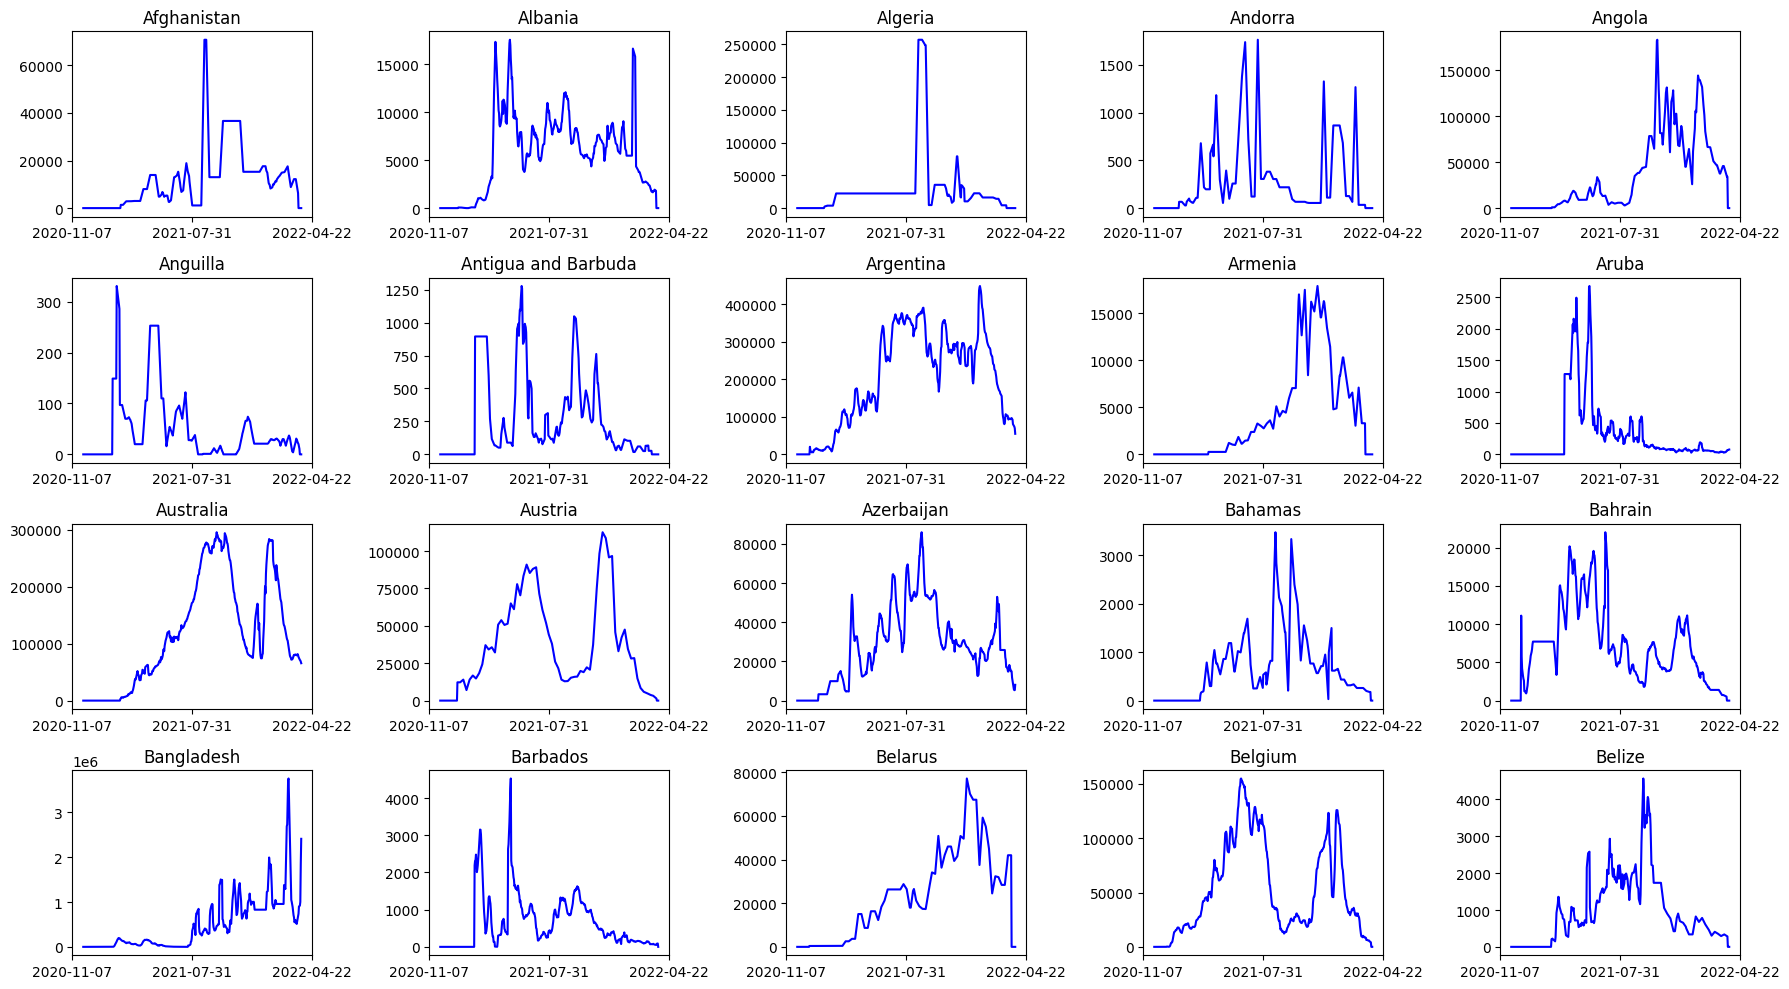

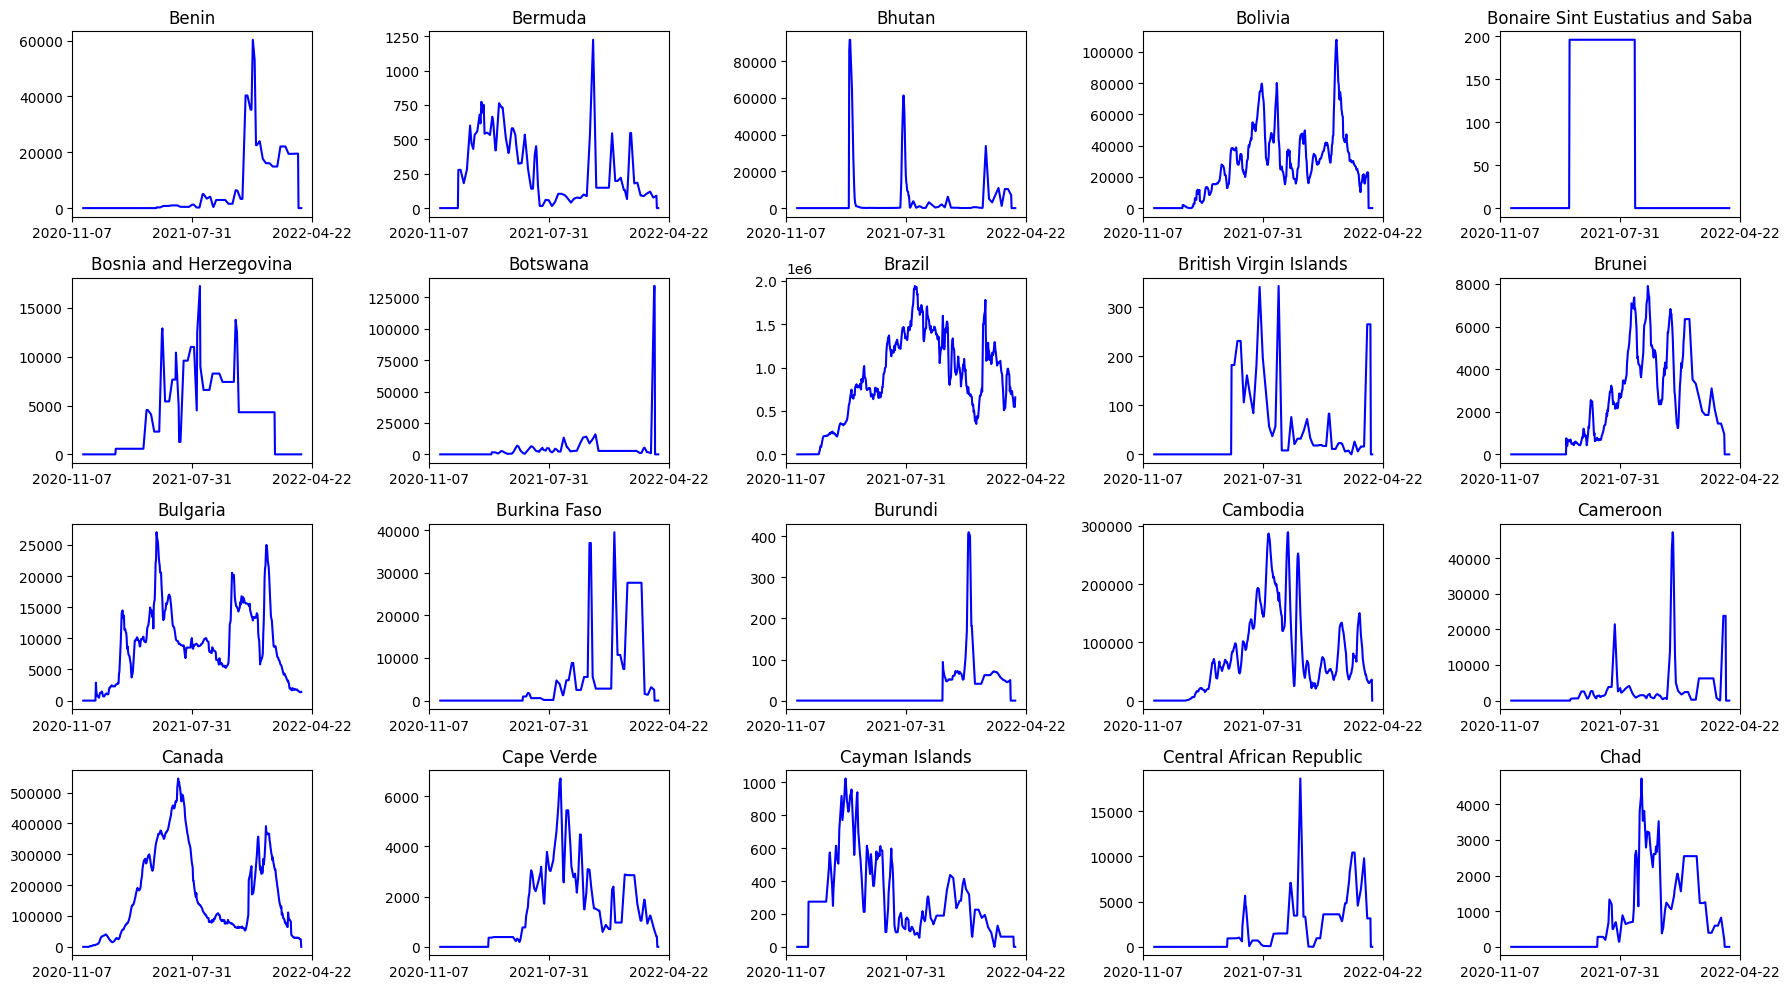

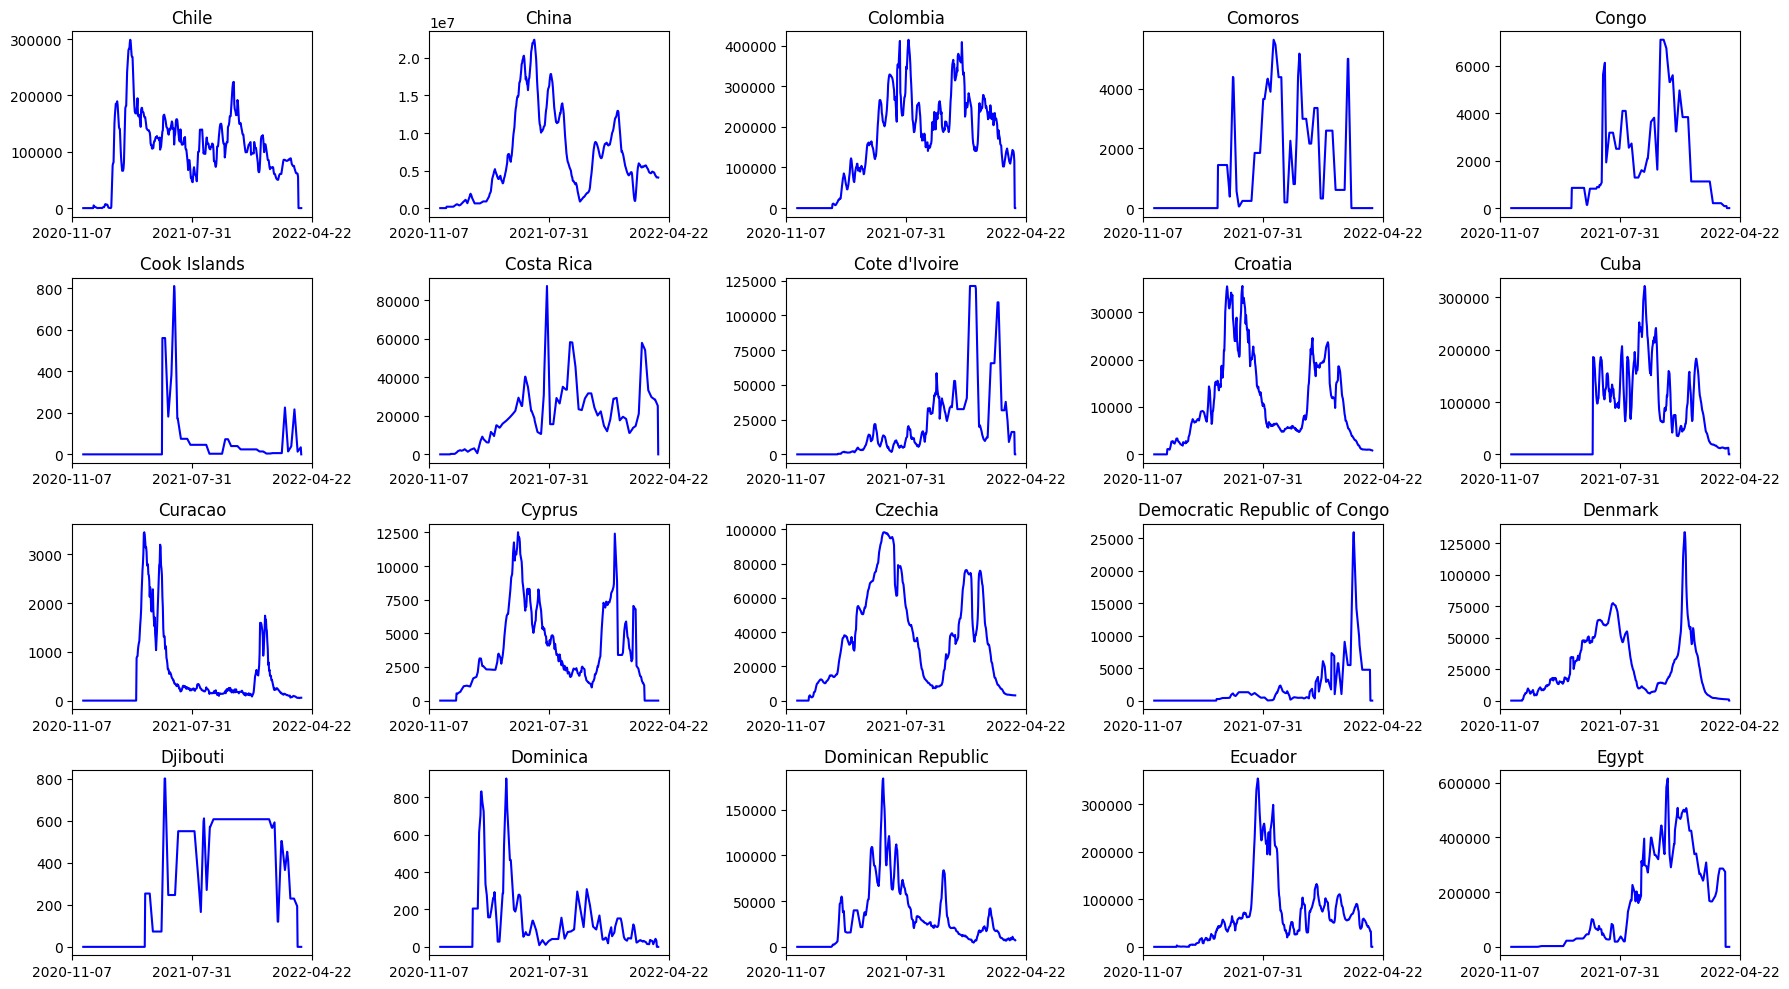

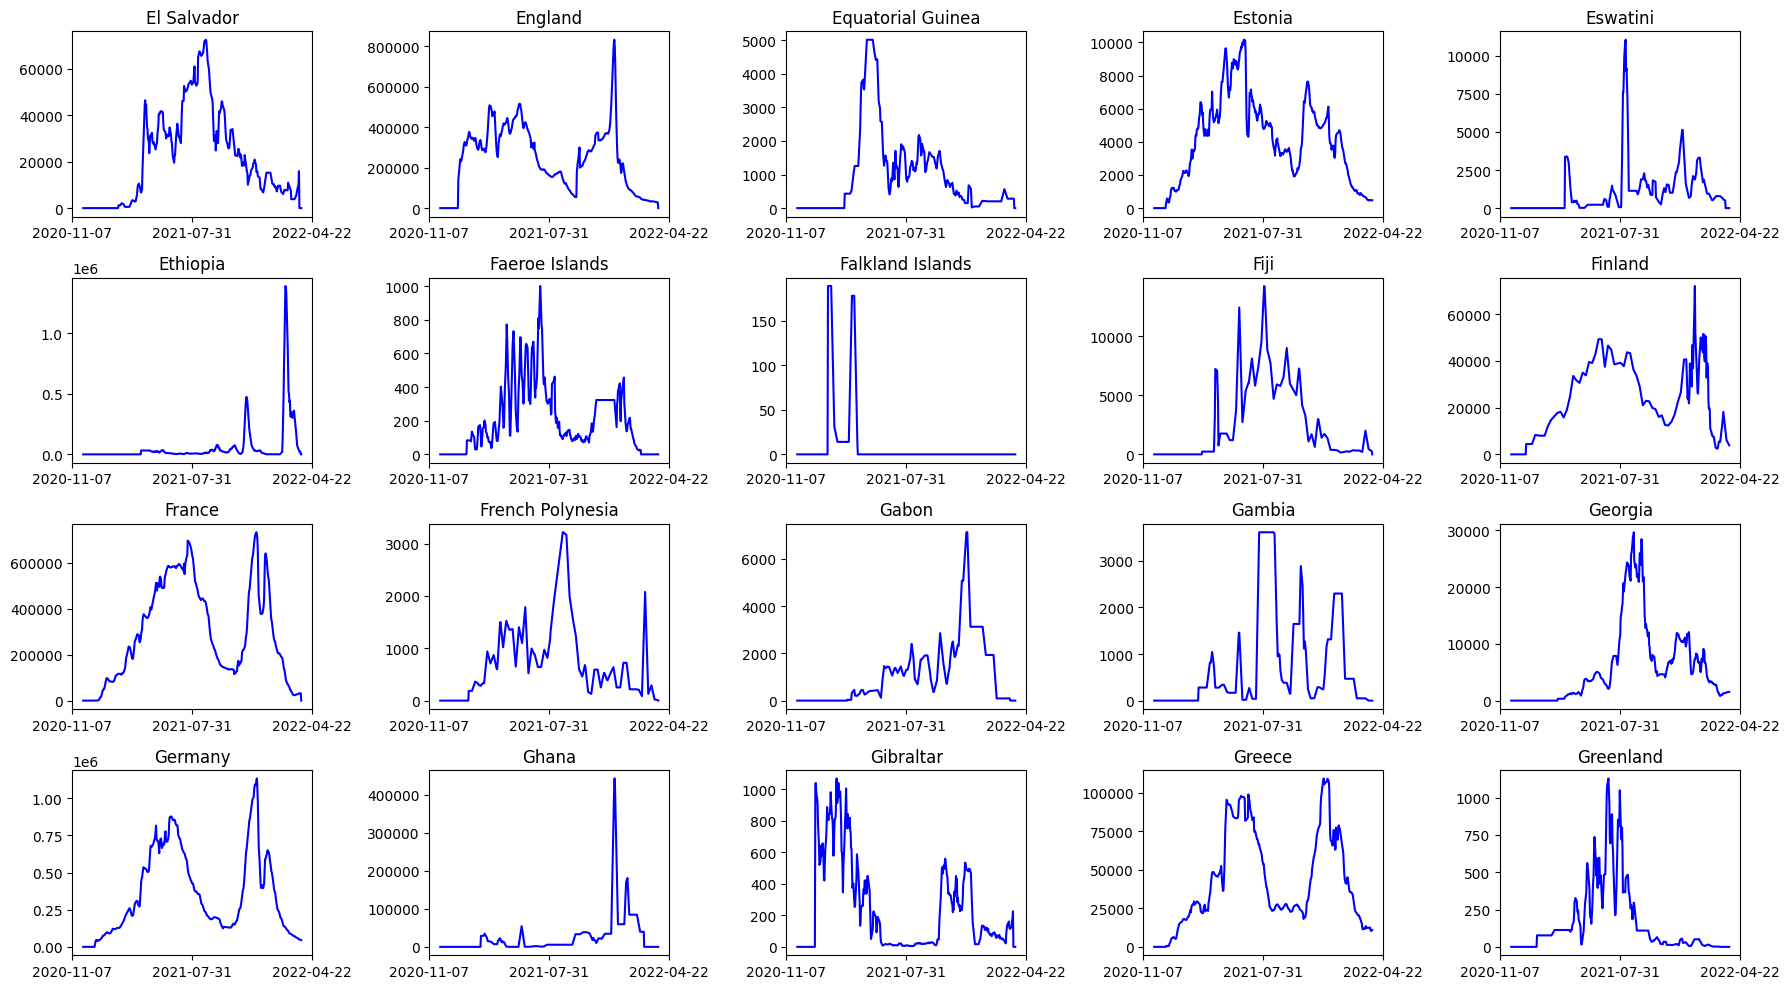

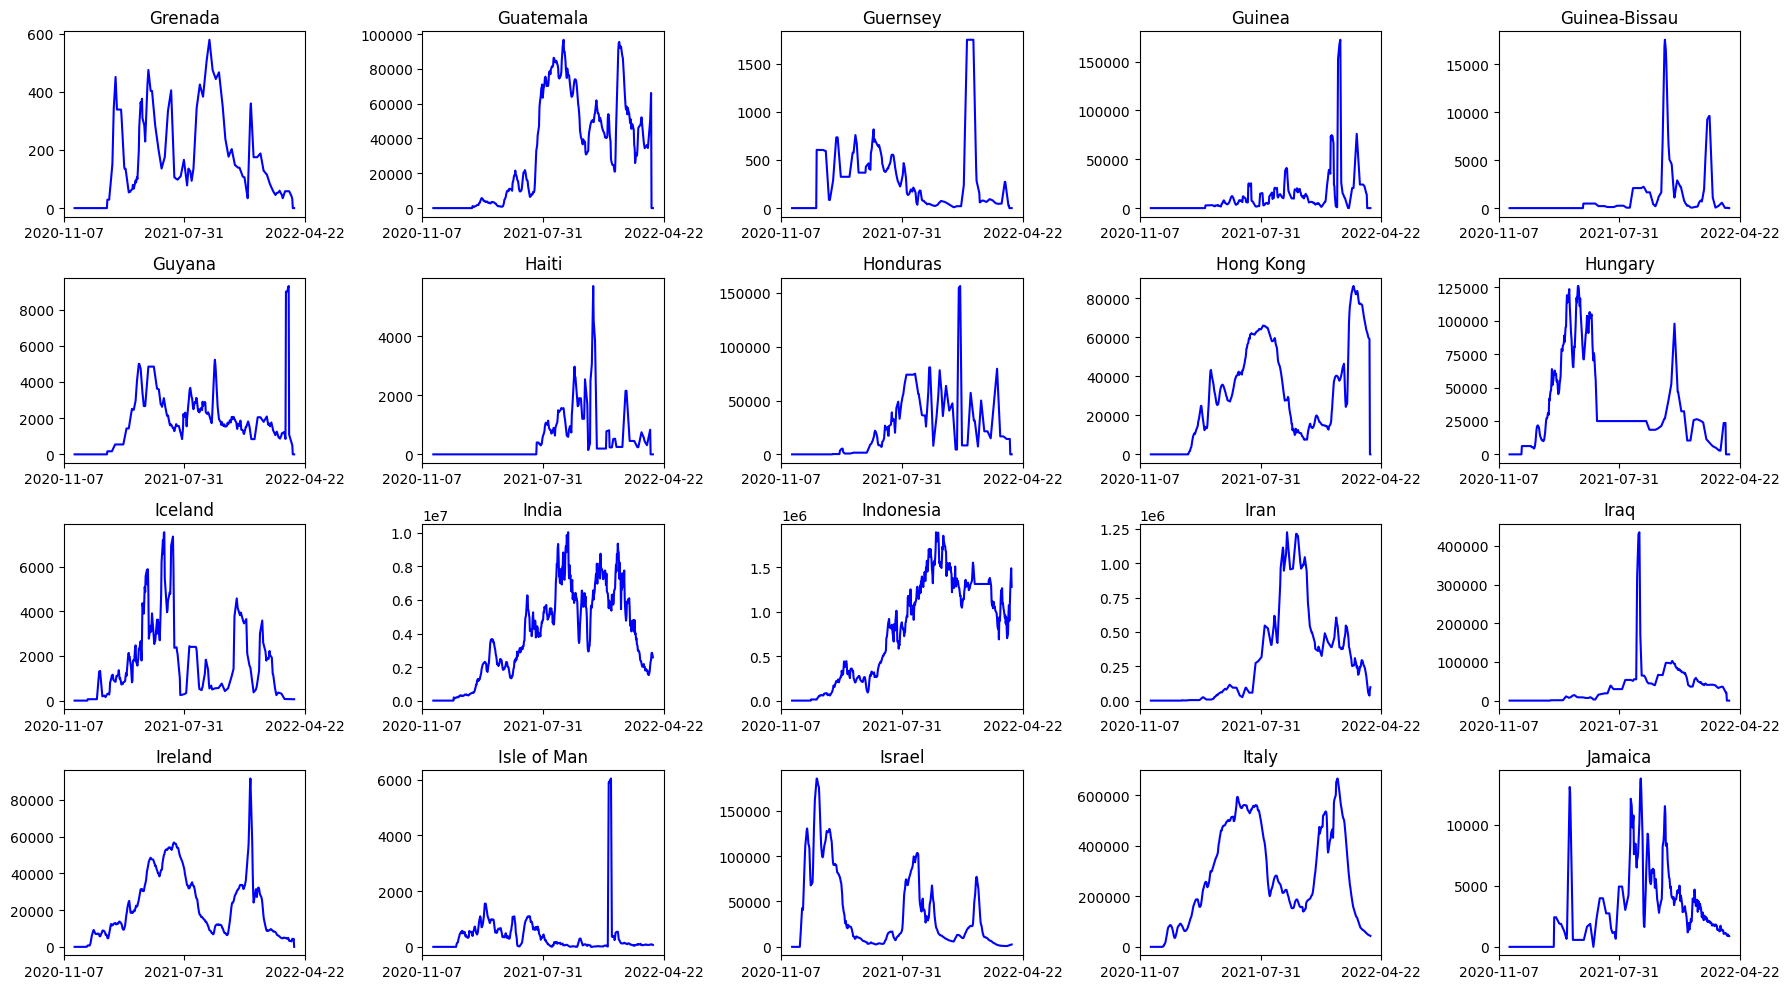

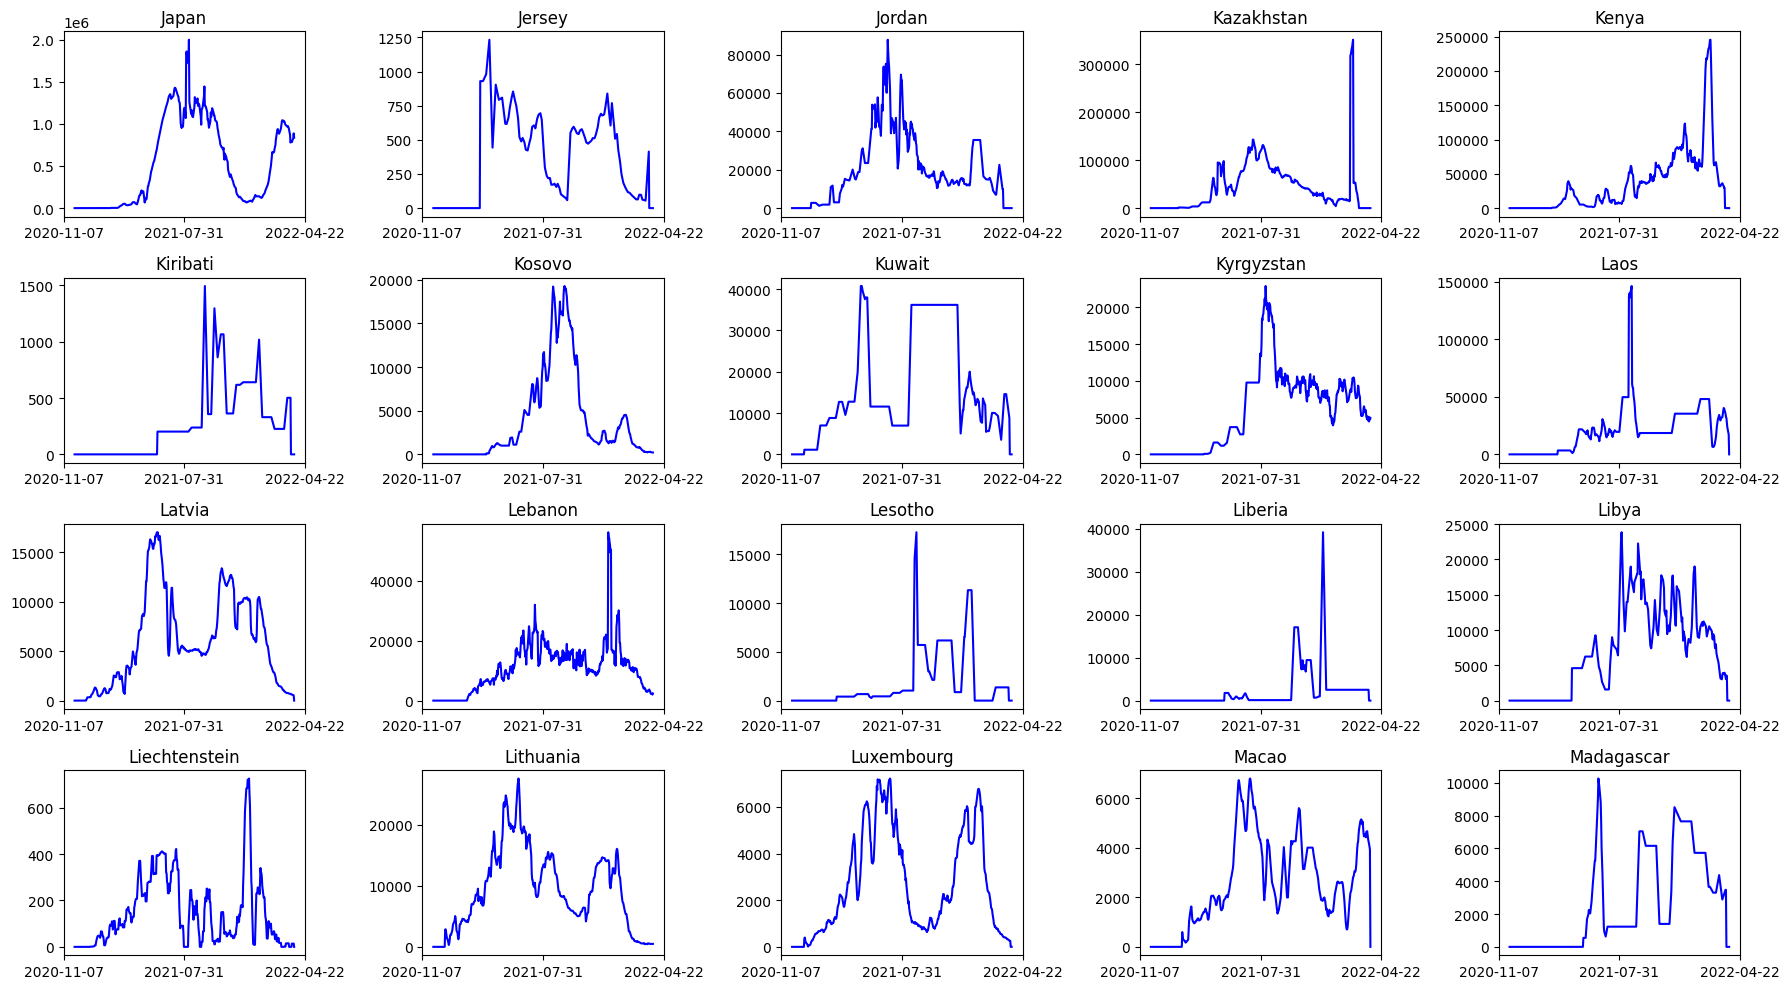

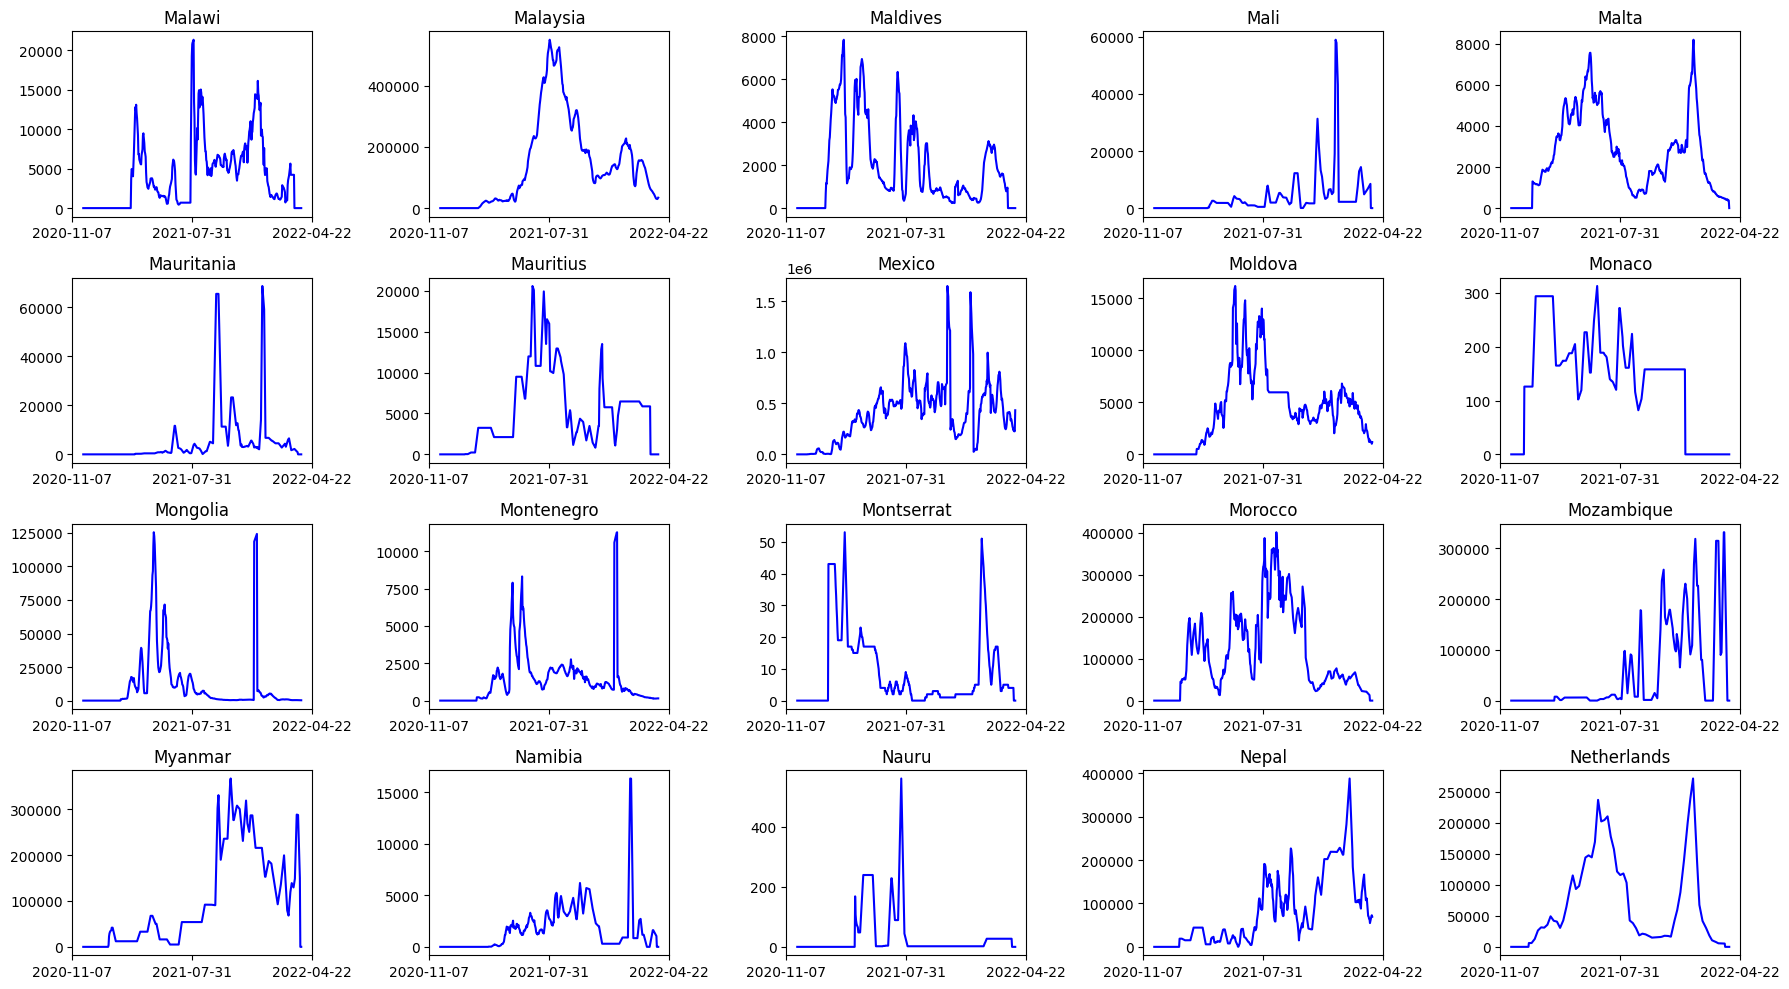

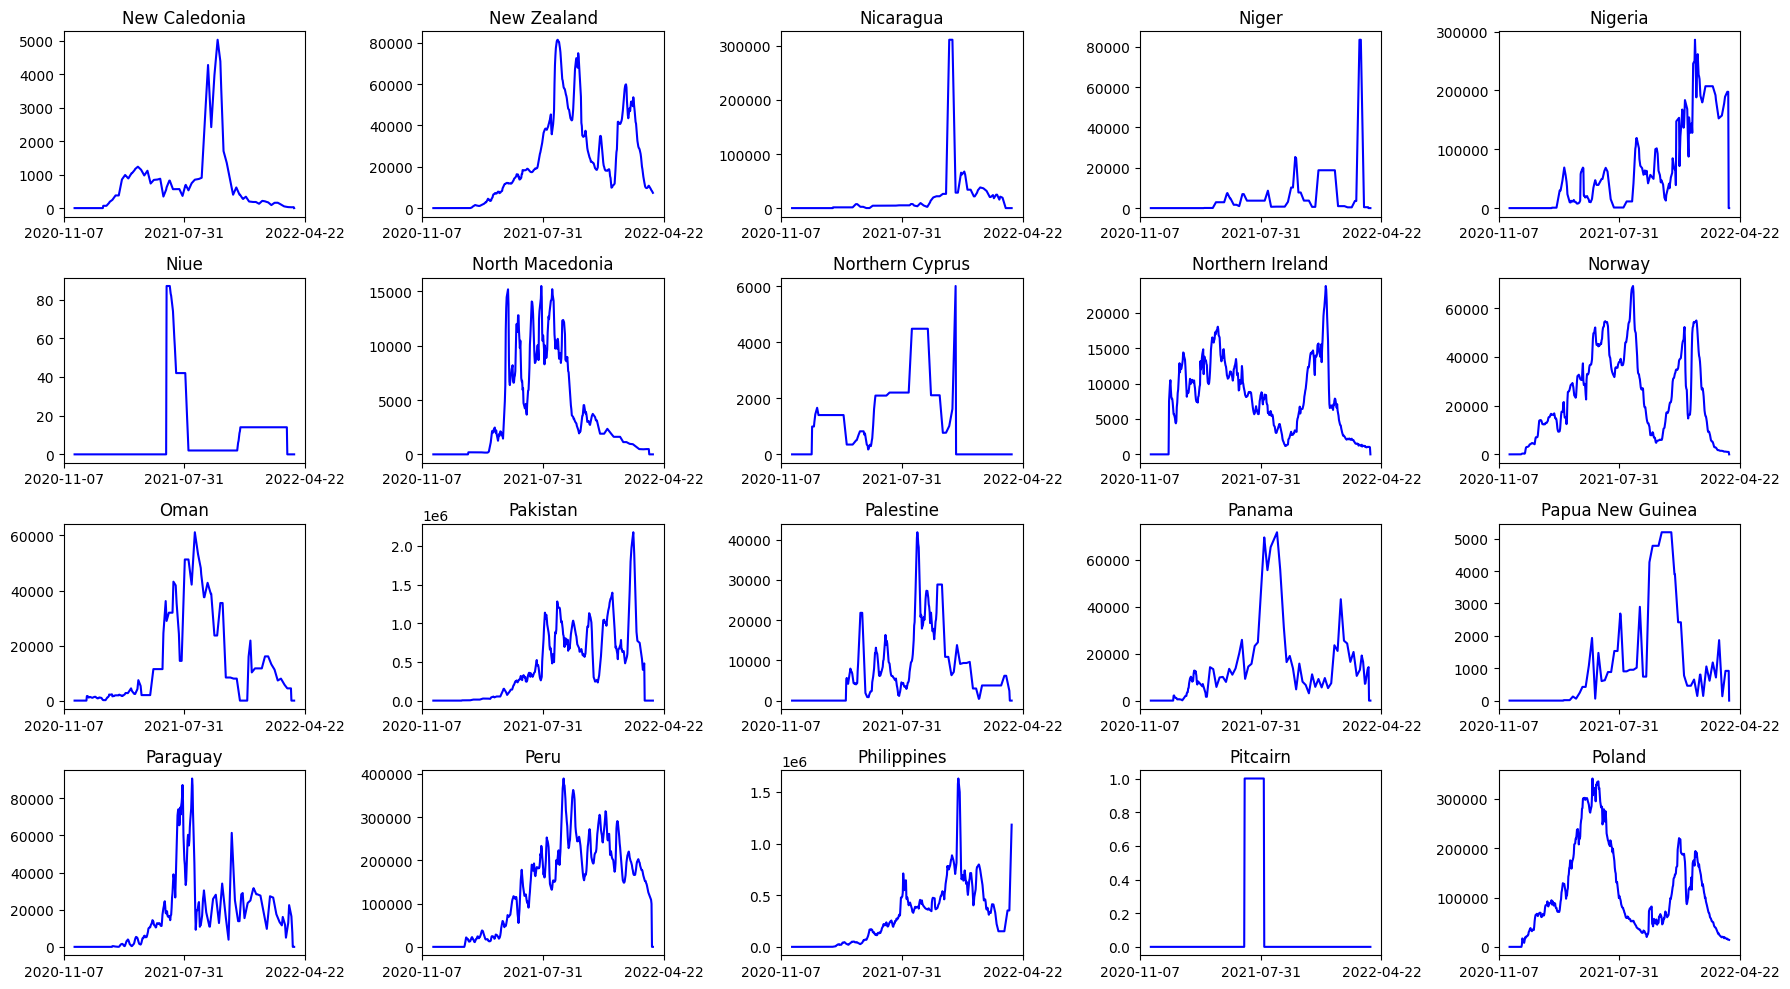

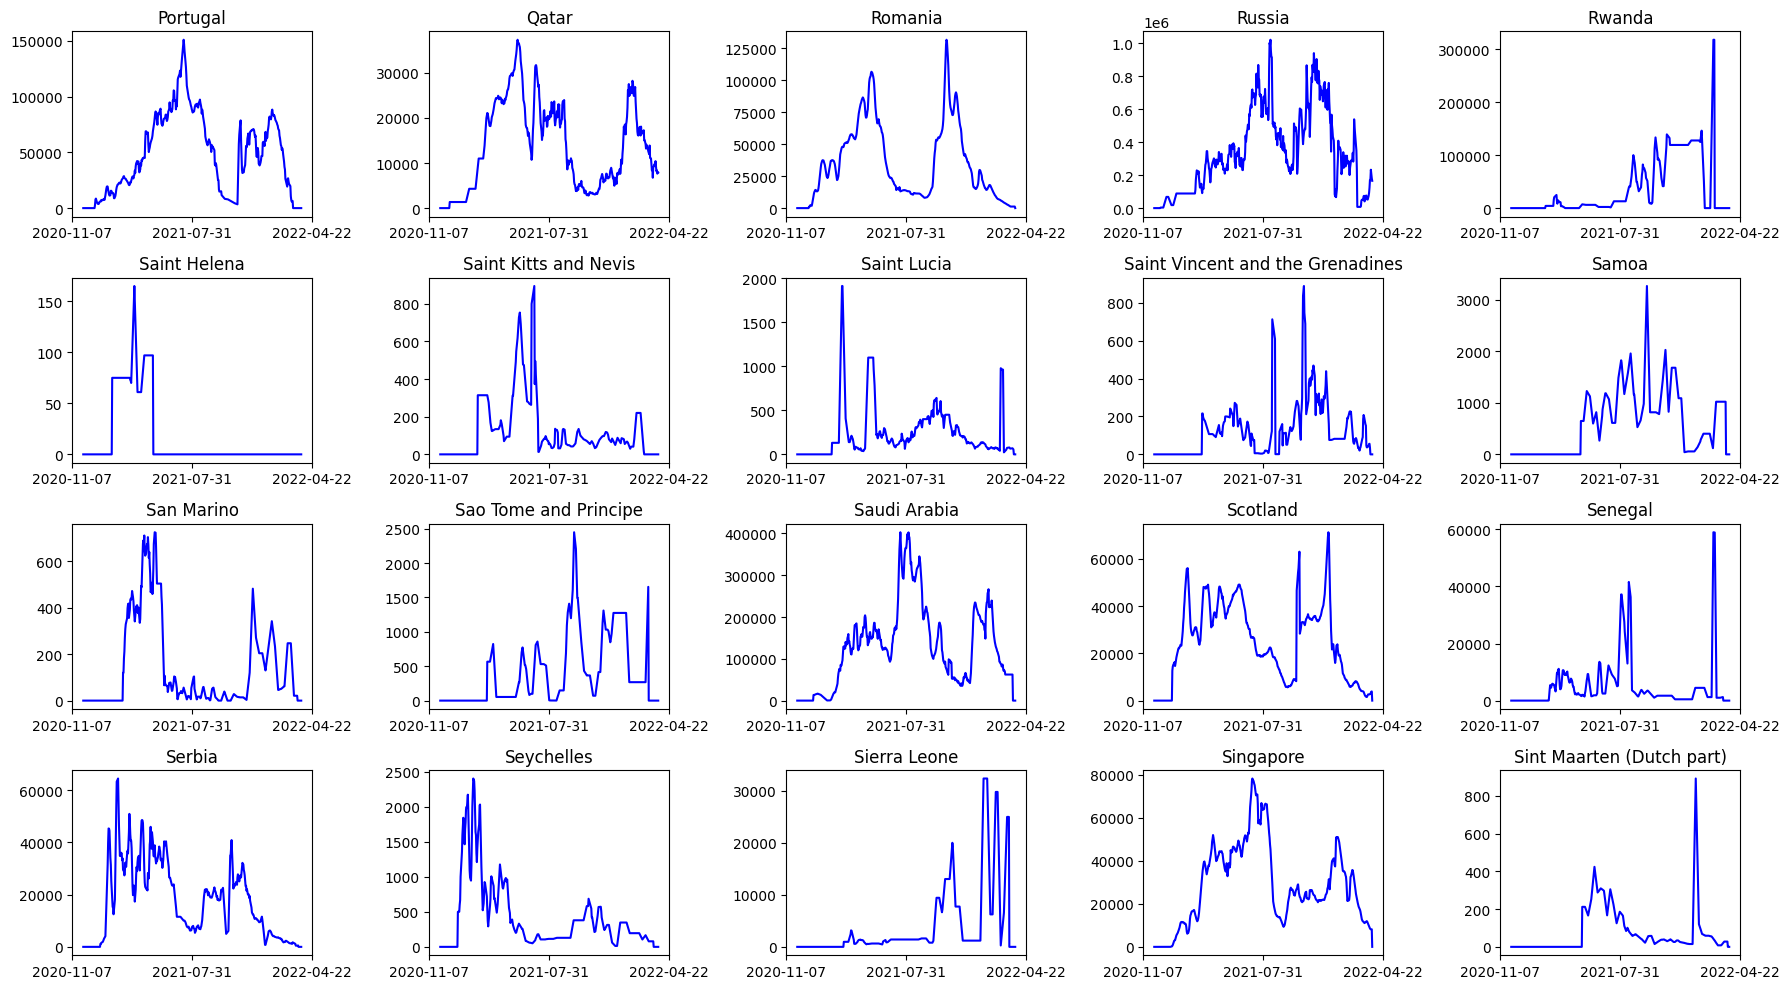

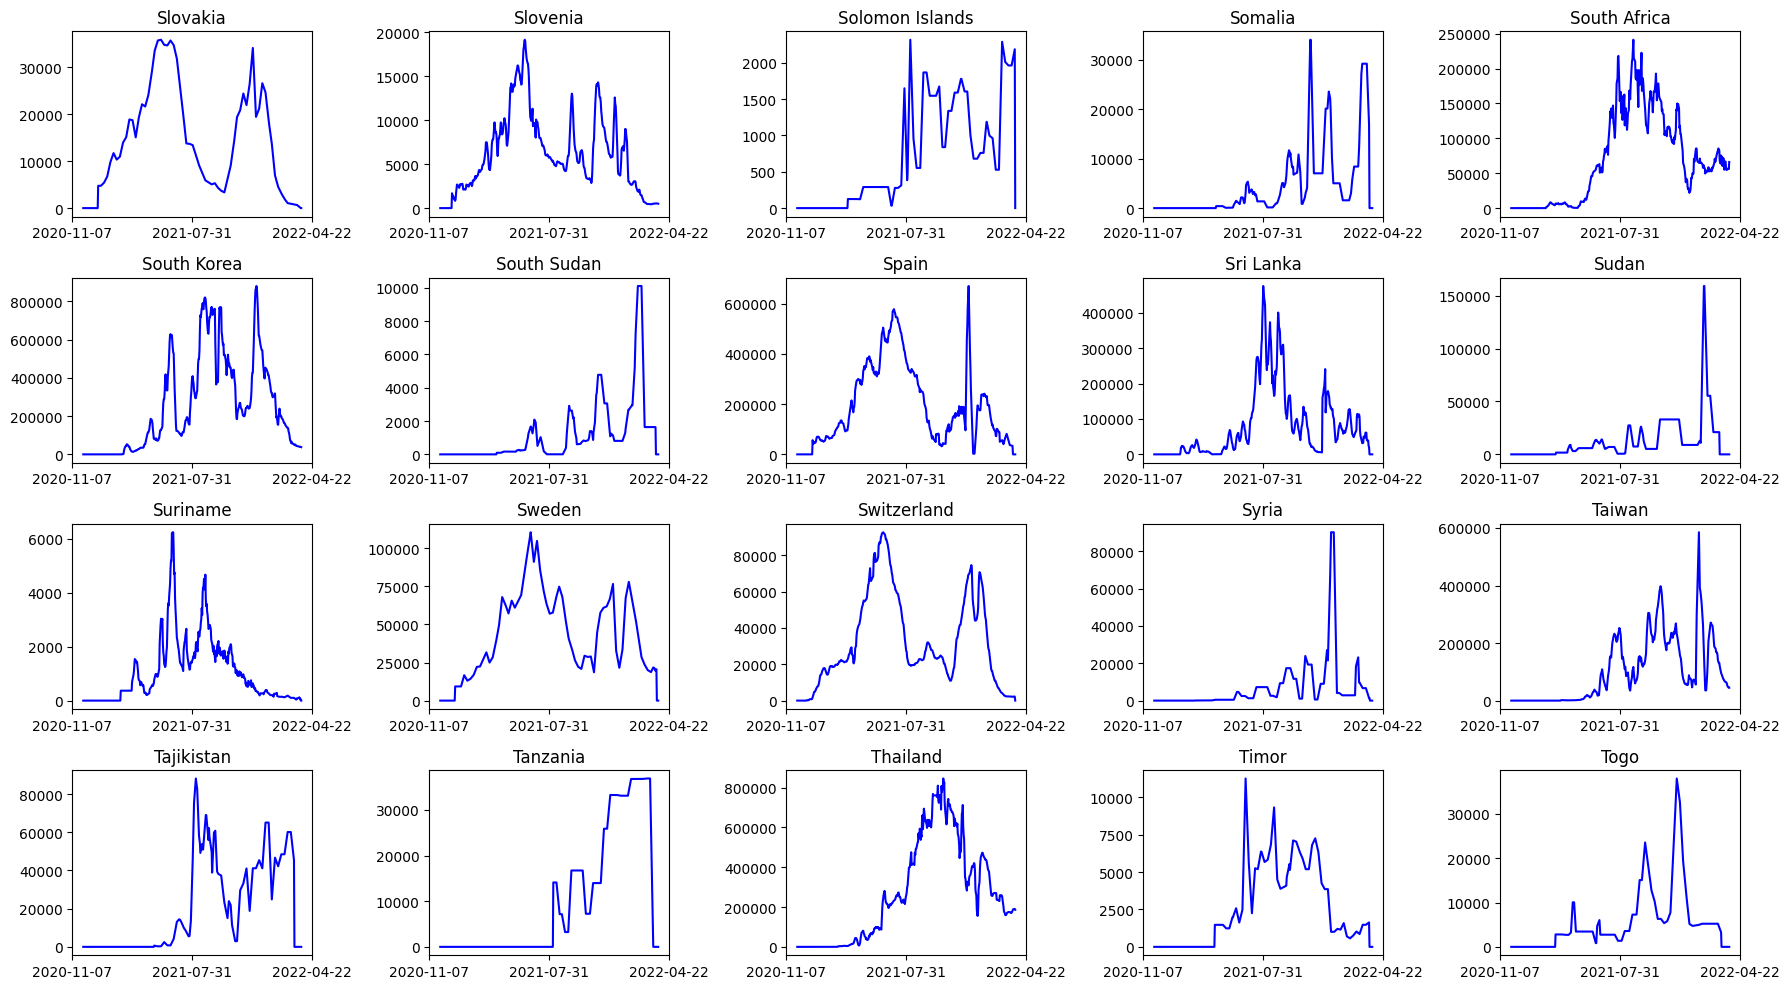

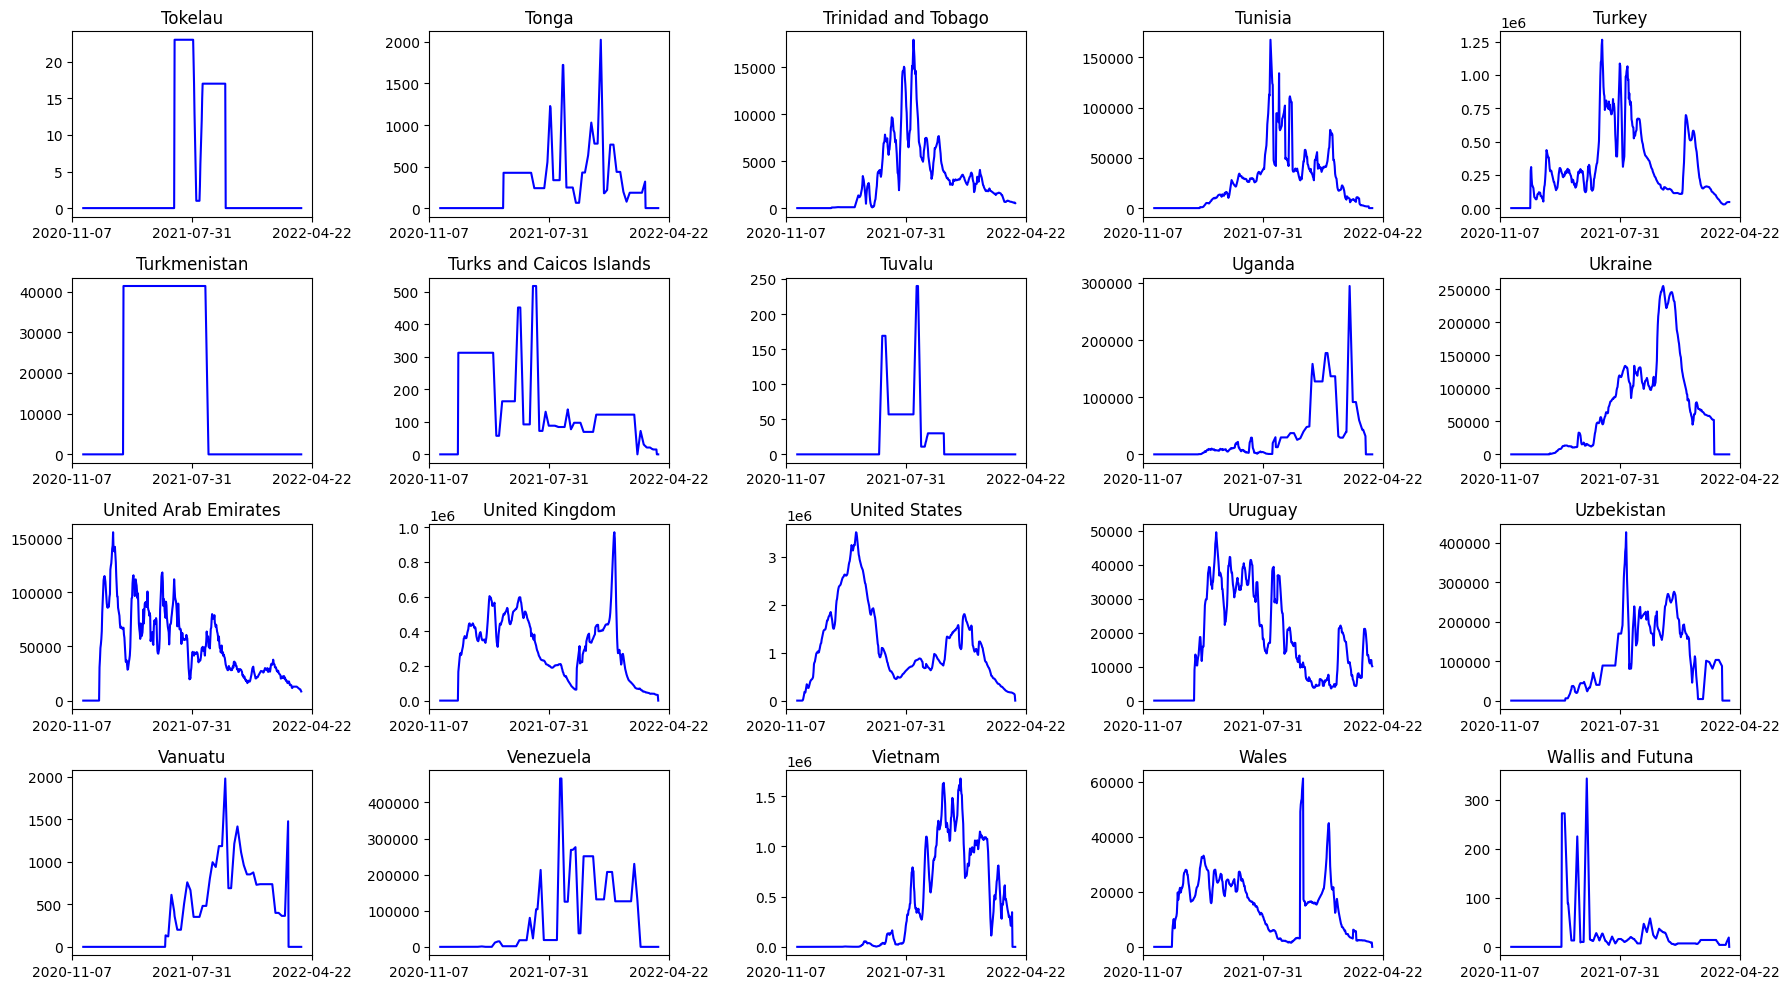

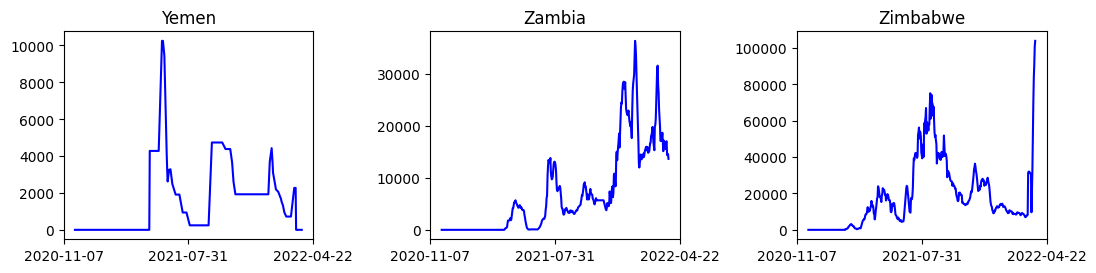

In [778]:
explore_dataset(cases_raw)

In [779]:
from sklearn.preprocessing import StandardScaler
from typing import Tuple

def standardize(dataframe: pd.DataFrame) -> Tuple[pd.DataFrame, StandardScaler]:

    scaler = StandardScaler()
    cases_standardized = pd.DataFrame(index=dataframe.index, columns=dataframe.columns, data=None)
    cases_standardized[cases_standardized.columns] = scaler.fit_transform(dataframe[dataframe.columns])
    return cases_standardized, scaler


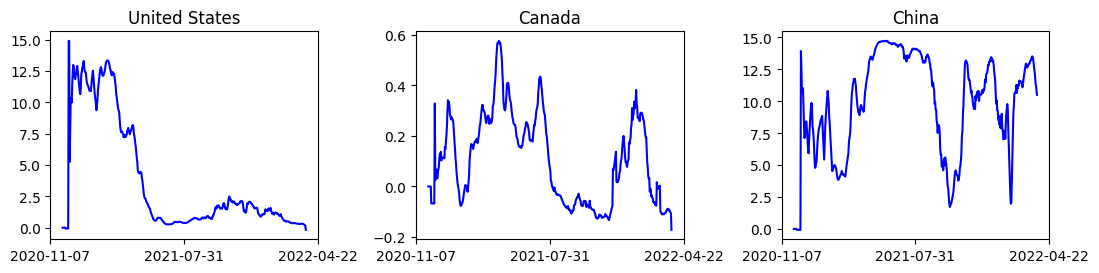

In [780]:
cases_std, scaler = standardize(cases_raw)
US_CAN_CHINA = cases_std.loc[['United States', 'Canada', 'China']]
explore_dataset(US_CAN_CHINA)

Since the features (dates) are standardized with zero mean and unit variance, the number of cases is relative to the mean for that day globally, meaning a negative score indicates that country had a lower case count than the global aberage. A positive case-score means the country had more cases that day than the global average. The US plateaus to around the global mean daily case count after 2021-07-31 whereas Canada and China remain almost consistently above average. 

# Part 2: Applying PCA [2 Marks]

1. Compute the covariance matrix of the dataframe. *Hint: The dimensions of your covariance matrix should be (511, 511).* **[0.25]**
2. Write a function `get_sorted_eigen(df_cov)` that gets the covariance matrix of dataframe `df` (from step 1), and returns sorted eigenvalues and eigenvectors using `np.linalg.eigh`. **[0.25]**
3. Show the effectiveness of your principal components in covering the variance of the dataset by superimposing the cumulative explained variance to a scree plot. **[0.25]**
4. How many PCs do you need to cover 99% of the dataset's variance? Write an expression for this. **[0.25]** **[0.25]**
5. Plot the first 16 principal components (Eigenvectors) as a time series (16 subplots, on the x-axis you have dates and on the y-axis you have the value of the PC element) . **[0.5]**
6. Compare the first two PCs with the rest of them. Do you see any difference in their trend? **[0.5]**

In [781]:
def get_cov_mat(data: np.ndarray) -> np.ndarray:
    '''
    Gets covariance matrix of an array of standardized data.
    '''
    n, _ = data.shape
    return np.dot(data.T, data) / (n-1) 


In [782]:
from typing import List
def get_sorted_eigen(covariance_mat: np.ndarray) -> List[float]:

    eigenValues, eigenVectors = np.linalg.eigh(covariance_mat) 
    args = (-eigenValues).argsort()
    eigenValues = eigenValues[args]
    eigenVectors = eigenVectors[:, args]
    return eigenValues, eigenVectors


In [783]:
cases_cov = get_cov_mat(cases_std)
eigenValues, eigenVectors = get_sorted_eigen(cases_cov)

In [784]:
def get_explained_variances(eigenvalues: np.ndarray) -> np.ndarray:
    eigValSum = sum(eigenvalues)
    expVar = [eigV/eigValSum*100 for eigV in eigenvalues]
    cumExpVar = np.cumsum(expVar)

    index_of_99 = (cumExpVar[:10] >= 99).tolist().index(True)
    print(index_of_99)

    plt.bar(range(1, 11), expVar[:10],  label='Explained Variance')
    plt.plot(range(1, index_of_99 + 1), cumExpVar[:index_of_99], 'r-o', label='Cumulative Explained Variance (< 99%)')
    plt.plot(range(index_of_99 + 1, 11), cumExpVar[index_of_99: 10], 'g-o', label='Cumulative Explained Variance (>= 99%)')
    plt.plot([1, 10], [99, 99], 'g:', label='99% Cumulative Explained Variance')
    plt.legend(loc='center right',)
    plt.xlabel("Principle Component")
    plt.ylabel("Percent Cumulative Variance")
    plt.title("Scree plot of the first 10 PCs")
    plt.show()

    return cumExpVar

In [ ]:
cumExpVar = get_explained_variances(eigenValues)

Let $x$ be the minimum number of principle components needed for $ \geq 99 \%$ cumulative variance, and $\lambda_i$ be the sorted decreasing eigenvalues of the covariance matrix.  Then 
$$ x = \min \{ i : \frac{\sum_{j = 1}^i \lambda_i}{\sum_{i = 1}^N \lambda_i} \geq 0.99 \} $$
In this case, $x = 8$. 

In [786]:
def plot_16_eigenvectors(eigenVectors: np.ndarray, features) -> None:
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.flatten()
    for i, (ev, ax) in enumerate(zip(eigenVectors[:16], axes)):
        ax.plot(features, ev, 'b-')
        ax.title.set_text("PC " + str(i + 1))
        xmin, xmax = ax.get_xlim()
        ax.set_xticks(np.round(np.linspace(xmin, xmax, 3), 2))
        
    fig.tight_layout() 
    plt.show()
    

In [ ]:
plot_16_eigenvectors(eigenVectors, cases_raw.columns)

# Part 3: Data reconstruction [3 Marks]

Create a function that:

*   Accepts a country and the original dataset as inputs.
*   Calls useful functions that you designed in previous parts to compute eigenvectors and eigenvalues. 
*   Plots 4 figures:
  1.   The original time-series for the specified country. **[0.5]**
  2.   The incremental reconstruction of the **original** (not standardized) time-series for the specified country in a single plot. **[1.5]**
       * You should at least show 5 curves in a figure for incremental reconstruction. For example, you can pick the following (or any other combination that you think is reasonable): 
          * Reconstruction with only PC1
          * Reconstruction with both PC1 and PC2
          * Reconstruction with PC1 to PC4 (First 4 PCs)
          * Reconstruction with PC1 to PC8 (First 8 PCs)
          * Reconstruction with PC1 to PC16 (First 16 PCs)

      * Hint: you need to compute the reconstruction for the standardized time-series first, and then scale it back to the original (non-standardized form) using the StandardScaler `inverse_transform` [help...](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.inverse_transform)
  3.   The residual error for your best reconstruction with respect to the original time-series. **[0.5]**
      * Hint: You are plotting the error that we have for reconstructing each day `(df - df_reconstructed)`. On the x-axis, you have dates, and on the y-axis, the residual error. 
  4.   The RMSE of the reconstruction as a function of the number of included components (x-axis is the number of components and y-axis is the RMSE). Sweep x-axis from 1 to 10 (this part is independent from part 3.2.) **[1]**

Test your function using the `United States`, `Canada`, and `China` as inputs. **[0.5]**


In [788]:
from sklearn.metrics import mean_squared_error

def plot_country_figures_PCA(original_df: pd.DataFrame, country_name: str, measurement: str ='Cases') -> Tuple[Tuple[int, np.ndarray], pd.DataFrame]:
    
    country_data = original_df.loc[[country_name]]


    # Country time series data
    fig, axes = plt.subplots(1, 1)
    axes.plot(country_data.columns, country_data.values[0], 'b-')
    xmin, xmax = axes.get_xlim()
    axes.set_xticks(np.round(np.linspace(xmin, xmax, 3), 2))
    axes.title.set_text(country_name)
    fig.supxlabel("Date")
    fig.supylabel(measurement)
    plt.show()
    plt.close()
    

    # incremental reconstruction
    fig, axes = plt.subplots(1, 5, figsize=(18, 4))
    cases_std, scaler = standardize(original_df)
    country_std = cases_std.loc[[country_name]]
    cases_cov = get_cov_mat(cases_std)
    eigenvalues, eigenvectors = get_sorted_eigen(cases_cov)
    eigenvectors = np.array(eigenvectors)
    PCs = eigenvectors[:, :16]

    recons = []

    for recon_num in range(5):
        W = PCs[:, :2**recon_num]
        recon = (country_std @ W) @ W.T
        data = scaler.inverse_transform(recon)[0]
        recons.append((2**recon_num, data))
        ax_recon = axes[recon_num]
        ax_recon.plot(original_df.columns, data, 'r-')
        ax_recon.title.set_text("First " + str(2**recon_num) + " PCs")
        xmin, xmax = ax_recon.get_xlim()
        ax_recon.set_xticks(np.round(np.linspace(xmin, xmax, 3), 2))

    fig.suptitle("Reconstruction from Principle Components (" + country_name + ")")
    fig.supxlabel("Date")
    fig.supylabel(measurement)
    fig.tight_layout() 
    plt.show()
    plt.close()


    # Residual errors from given number of PC reconstruction
    fig, axes = plt.subplots(1, 1, figsize=(4, 4))
    xmin, xmax = ax_recon.get_xlim()
    axes.set_xticks(np.round(np.linspace(xmin, xmax, 3), 2))
    for i, data in recons:
        axes.plot(original_df.columns, (country_data - data).values[0], label="First " + str(i) + " PCs")

    fig.tight_layout() 
    plt.legend()
    plt.title("Residual Errors")
    plt.xlabel("Date")
    plt.ylabel("Residual Error (Actual - Reconstructed)")
    plt.show()
    plt.close()


    # RMSE 
    rmse = pd.DataFrame(index=list(range(1, 11)), columns=['RMSE'])
    rmse.index.name = 'Number of PCs'
    for recon_num in range(10):
        W = PCs[:, :recon_num]
        recon = (country_std @ W) @ W.T
        data = scaler.inverse_transform(recon)[0]
        rmse.iloc[recon_num] = mean_squared_error(y_true=country_data.values[0], y_pred=data, squared=False)

    return recons, rmse




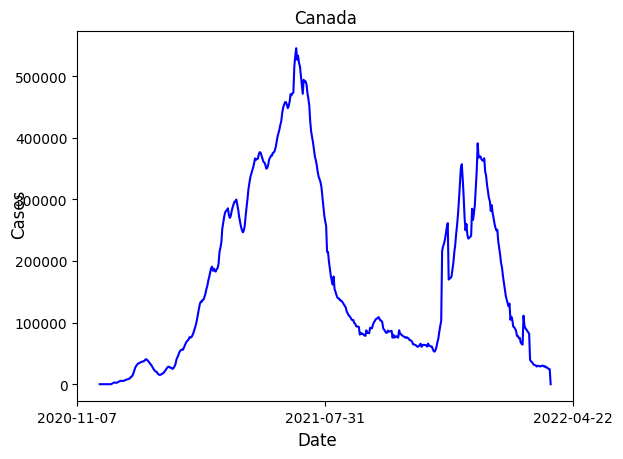

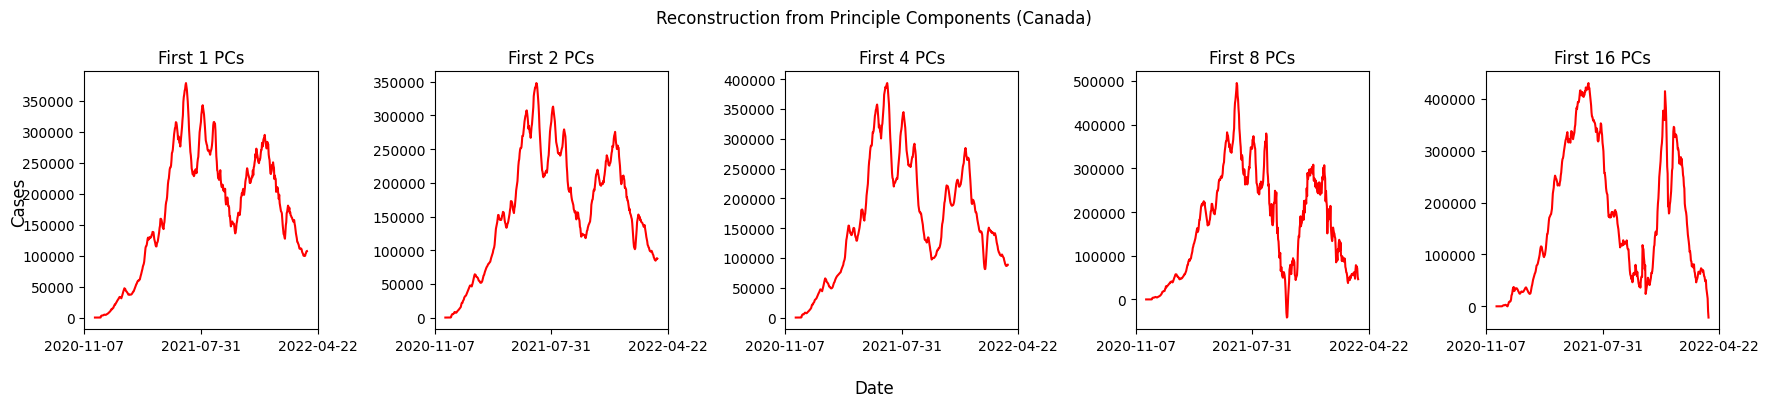

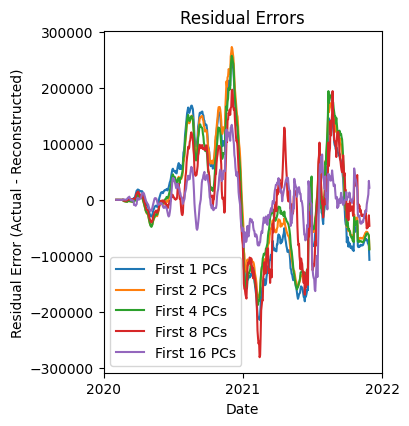

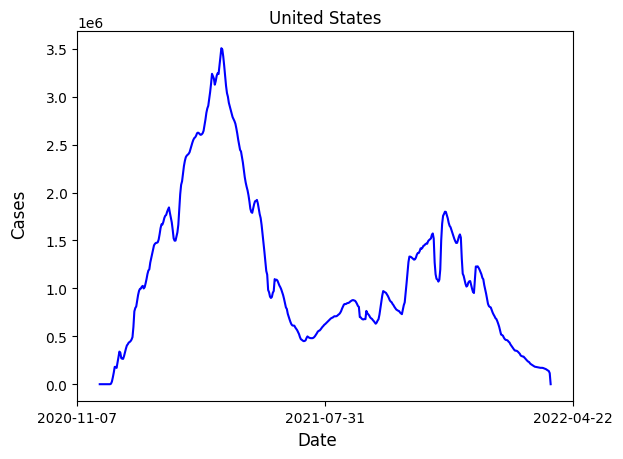

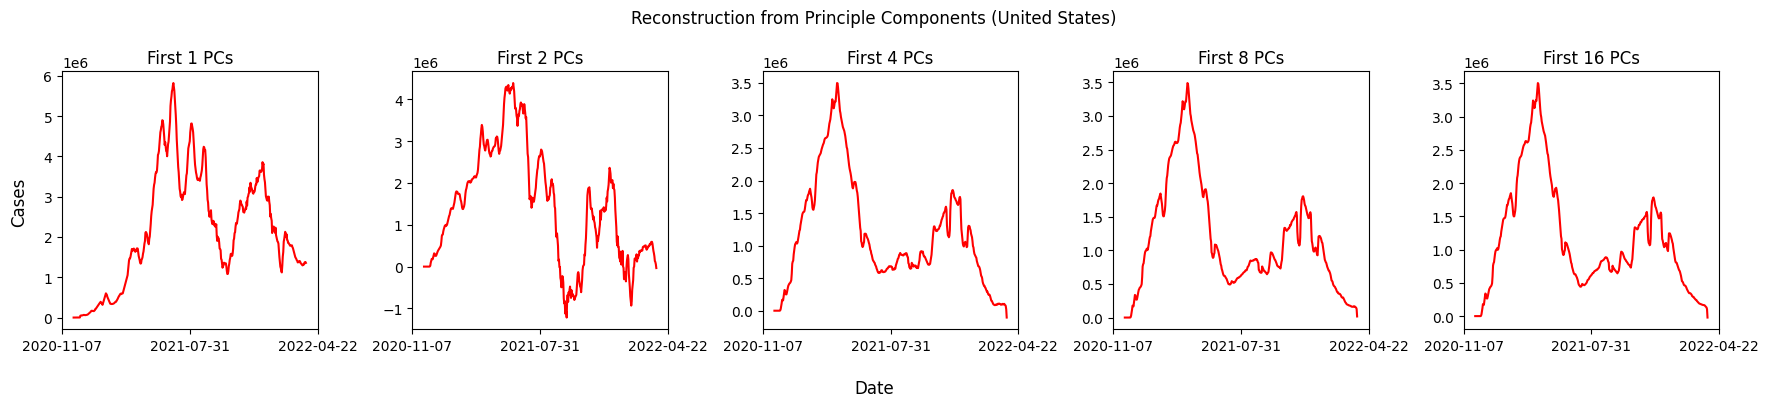

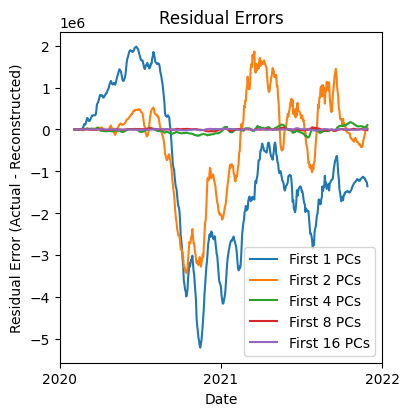

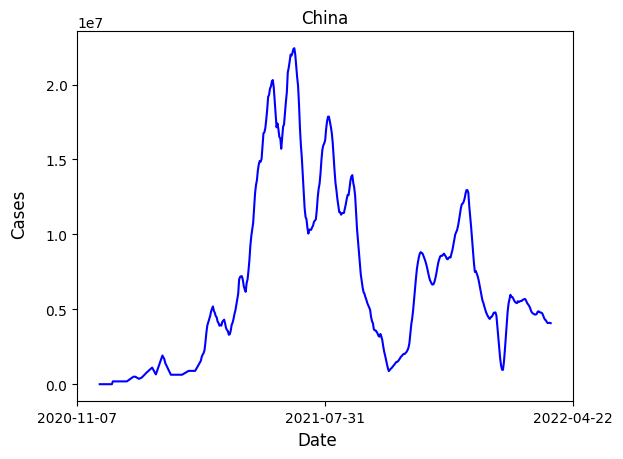

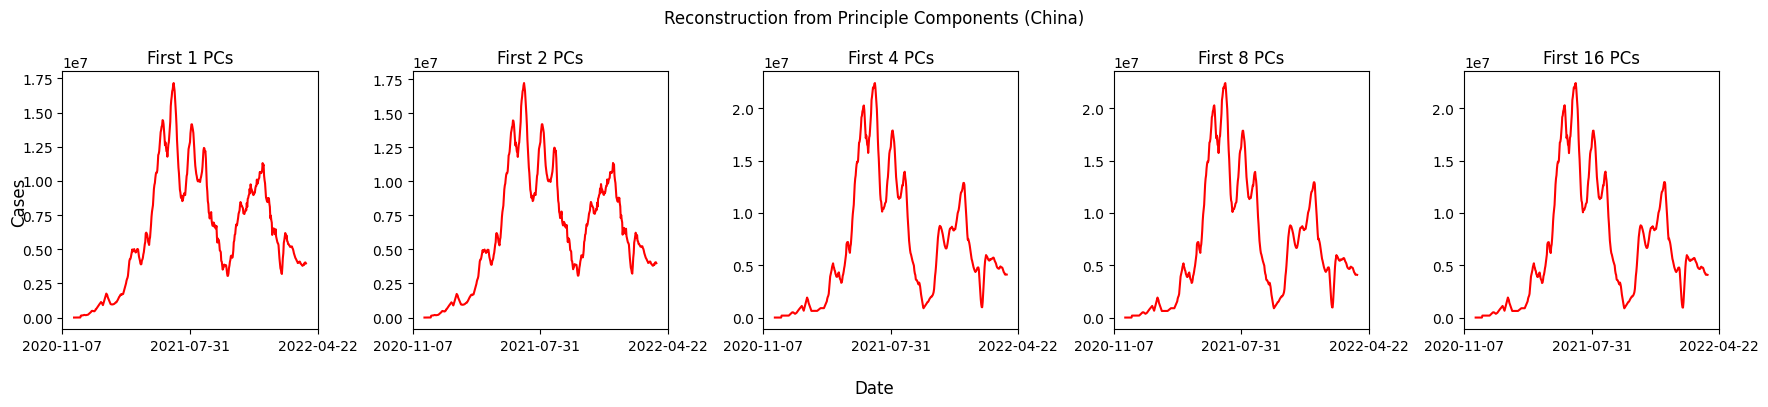

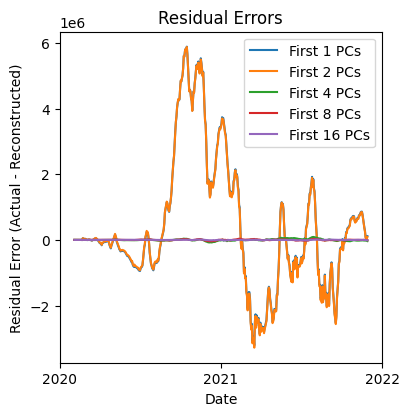

In [789]:
PCA_data = {
    'Canada'        : plot_country_figures_PCA(cases_raw, "Canada"),
    'United States' : plot_country_figures_PCA(cases_raw, "United States"),
    'China'         : plot_country_figures_PCA(cases_raw, "China")
}

# Part 4: SVD [2 Marks]
Modify your code in part 3 to use SVD instead of PCA for extracting the eigenvectors. **[1]**

Explain if standardization or covariance computation is required for this part.
Repeat part 3 and compare your PCA and SVD results. Write a function to make this comparison **[0.5]**, and comment on the results. **[0.5]**.

In [790]:
from scipy.linalg import svd

def plot_country_figures_SVD(original_df: pd.DataFrame, country_name: str, measurement: str = 'Cases') -> Tuple[Tuple[int, np.ndarray], pd.DataFrame]:
    
    country_data = original_df.loc[[country_name]]


    """ # Country time series data
    fig, axes = plt.subplots(1, 1)
    axes.plot(country_data.columns, country_data.values[0], 'b-')
    xmin, xmax = axes.get_xlim()
    axes.set_xticks(np.round(np.linspace(xmin, xmax, 3), 2))
    axes.title.set_text(country_name)
    fig.supxlabel("Date")
    fig.supylabel("Cases")
    plt.show()
    plt.close() """
    

    # incremental reconstruction
    fig, axes = plt.subplots(1, 5, figsize=(18, 4))
    cases_std, scaler = standardize(original_df)
    U, s, VT = svd(original_df)

    PCs = VT[:16, :]
    recons = []

    for recon_num in range(5):
        W = PCs[:2**recon_num, :].T
        data = country_data @ W @ W.T
        data = data.values[0]
        recons.append((2**recon_num, data))
        ax_recon = axes[recon_num]
        ax_recon.plot(original_df.columns, data, 'r-')
        ax_recon.title.set_text("First " + str(2**recon_num) + " PCs")
        xmin, xmax = ax_recon.get_xlim()
        ax_recon.set_xticks(np.round(np.linspace(xmin, xmax, 3), 2))

    fig.suptitle("Reconstruction from Principle Components (" + country_name + ")")
    fig.supxlabel("Date")
    fig.supylabel(measurement)
    fig.tight_layout() 
    plt.show()
    plt.close()


    # Residual errors from given number of PC reconstruction
    fig, axes = plt.subplots(1, 1, figsize=(4, 4))
    xmin, xmax = ax_recon.get_xlim()
    axes.set_xticks(np.round(np.linspace(xmin, xmax, 3), 2))
    for i, data in recons:
        axes.plot(original_df.columns, (country_data - data).values[0], label="First " + str(i) + " PCs")

    fig.tight_layout() 
    plt.legend()
    plt.title("Residual Errors")
    plt.xlabel("Date")
    plt.ylabel("Residual Error (Actual - Reconstructed)")
    plt.show()
    plt.close()


    # RMSE 
    rmse = pd.DataFrame(index=list(range(1, 11)), columns=['RMSE'])
    rmse.index.name = 'Number of PCs'
    for recon_num in range(10):
        W = PCs[:recon_num, :].T
        data = country_data @ W @ W.T
        data = data.values[0]
        rmse.iloc[recon_num] = mean_squared_error(y_true=country_data.values[0], y_pred=data, squared=False)

    return recons, rmse

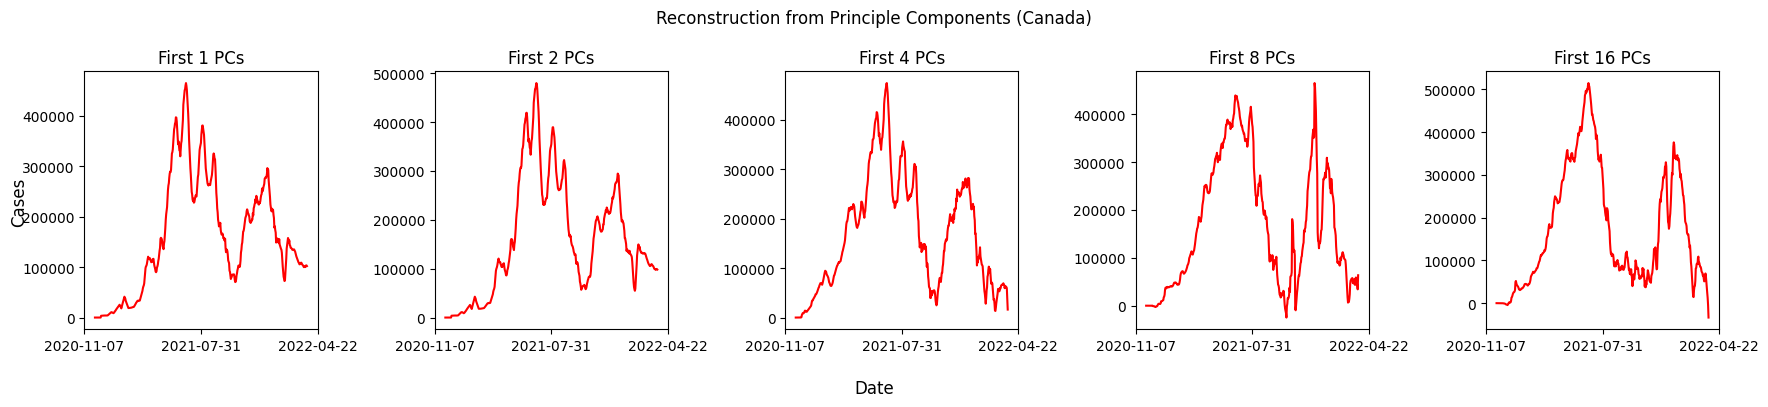

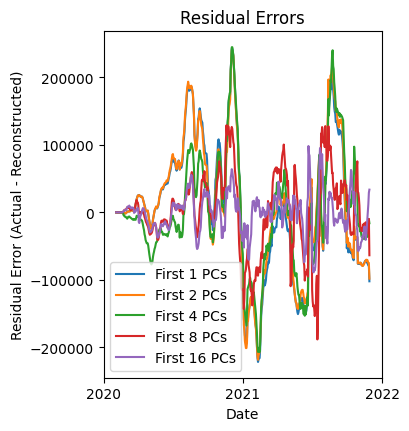

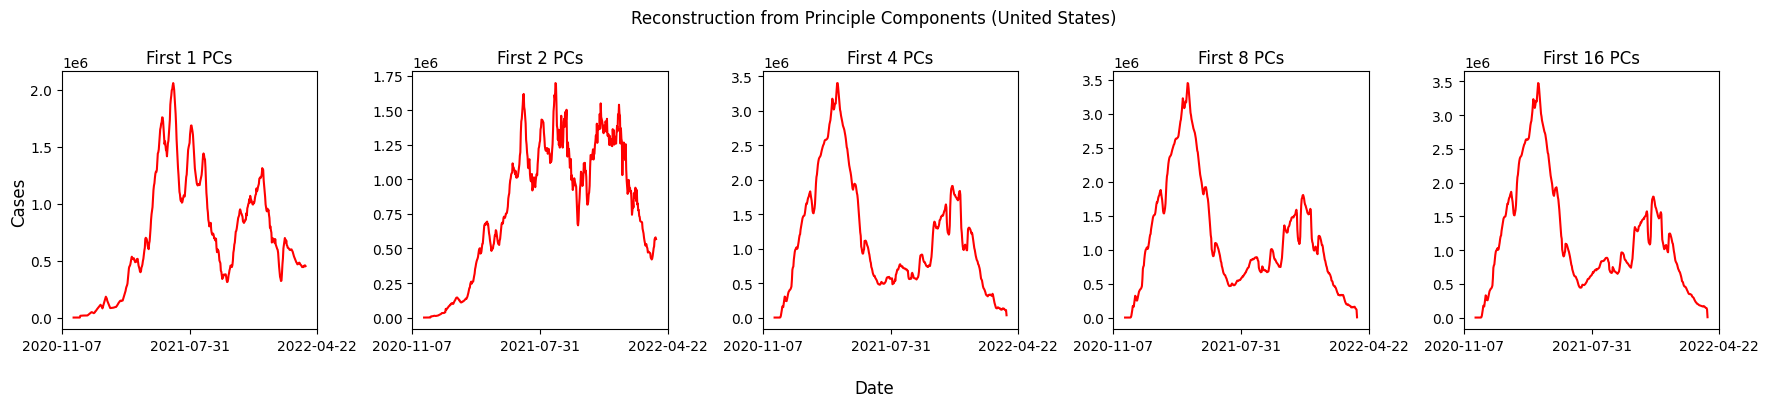

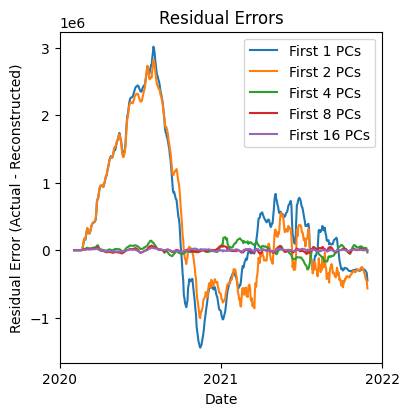

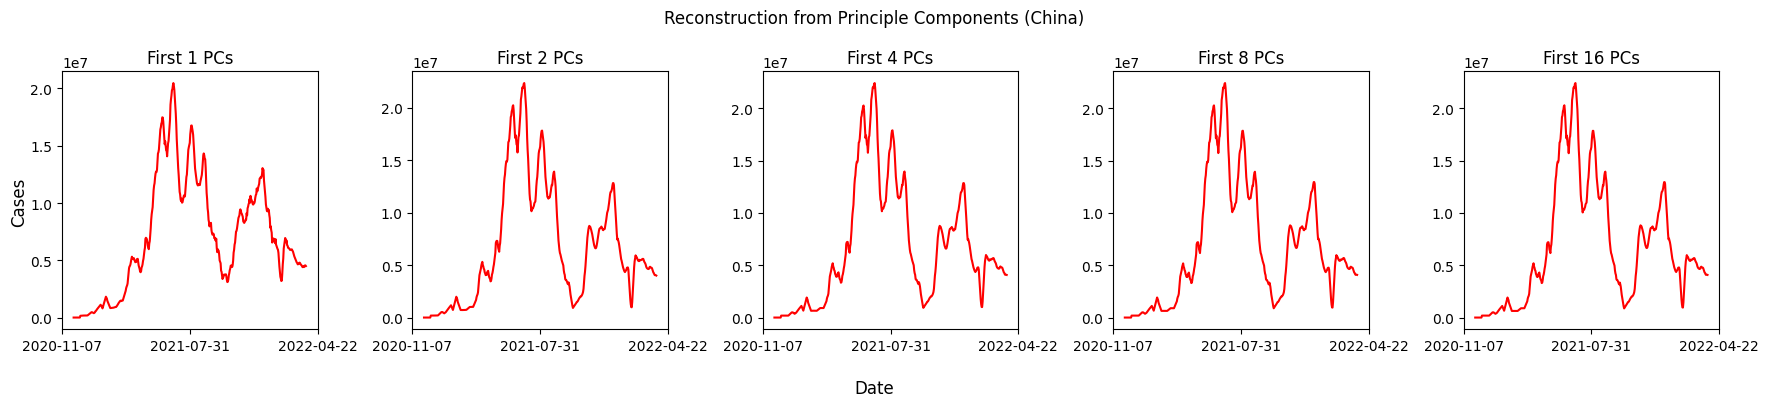

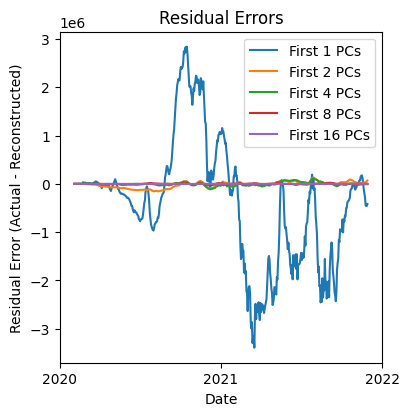

In [791]:
SVD_data = {
    'Canada'        : plot_country_figures_SVD(cases_raw, "Canada"),
    'United States' : plot_country_figures_SVD(cases_raw, "United States"),
    'China'         : plot_country_figures_SVD(cases_raw, "China")
}

In [792]:
def compare_PCA_SVD(PCArmse: pd.DataFrame, SVDrmse: pd.DataFrame) -> pd.DataFrame:

    comparison = pd.DataFrame(index=list(range(1, 11)), columns=['PCA RMSE', 'SVD RMSE', 'Difference (SVD - PCA)'])
    comparison['PCA RMSE'] = PCArmse.iloc[:, 0]
    comparison['SVD RMSE'] = SVDrmse.iloc[:, 0]
    comparison['Difference (SVD - PCA)'] =  SVDrmse.iloc[:, 0] - PCArmse.iloc[:, 0]

    return comparison

In [793]:
compare_PCA_SVD(PCA_data['Canada'][1], SVD_data['Canada'][1])


PCA RMSE       SVD RMSE Difference (SVD - PCA)
1   133789.245364  221855.568392           88066.323028
2   105134.474703   98010.767324           -7123.707379
3    99057.781785   97418.783358           -1638.998427
4    94259.498423   87947.849058           -6311.649365
5    94288.074446   85876.709467           -8411.364979
6    88251.911049   85857.378523           -2394.532527
7    86360.544149   82127.660302           -4232.883847
8    83808.041194   82084.378482           -1723.662713
9    82515.135196    57980.64609          -24534.489107
10   82924.693613   57618.756483           -25305.93713

In [794]:
compare_PCA_SVD(PCA_data['United States'][1], SVD_data['United States'][1])


PCA RMSE        SVD RMSE Difference (SVD - PCA)
1   1338511.649811  1417867.352979           79355.703168
2   1996272.281708  1111788.699566         -884483.582142
3   1213454.614165  1064634.760186         -148819.853979
4     69242.615681   110285.717082           41043.101402
5     69187.526774    75460.055524             6272.52875
6     41610.235426    55670.315403           14060.079977
7     29142.892932    55420.411619           26277.518687
8     31250.771374    55000.652492           23749.881117
9     15079.045827    24389.618086            9310.572259
10     15752.40748    24145.179414            8392.771934

In [795]:
compare_PCA_SVD(PCA_data['China'][1], SVD_data['China'][1])

PCA RMSE        SVD RMSE Difference (SVD - PCA)
1   8751694.563669  8860845.601538          109151.037869
2   2052843.950472  1342015.162167         -710828.788305
3   2052699.431026    64984.094473        -1987715.336553
4     27038.817665    37560.561122           10521.743457
5     27042.323005    36283.231364            9240.908359
6      26480.12478    18166.623604           -8313.501176
7     22570.944004    16428.833096           -6142.110908
8     22977.657002    16258.656346           -6719.000655
9     12762.959379     8422.864214           -4340.095164
10    12906.962979     7902.373816           -5004.589164

For Canada and China, SVD outperformed PCA and had a lower RMSE score for the majority of principal components used.
The standardized and covariance matrices are not required to find the eigenvectors using SVD, since SVD only requires $A \cdot A^T$ and $A^T \cdot A$ to compute the left and right eigenvectors + singular values. 

# Part 5: Let's collect another dataset! [2 Marks]
Create another dataset similar to the one provided in your handout using the raw information on COVID deaths (not vaccinations) provided [here](https://datahub.io/core/covid-19#resource-time-series-19-covid-combined). **[1]**

You need to manipulate the data to organize it in the desired format (i.e., the same format that was in previous parts). You are free to use any tools you like, from Excel to Python!
 
In the end, you should have a new CSV file with more dates (features) compared to the provided dataset. 


Upload your new dataset (in CSV format) to your colab notebook and repeat part 4. When analyzing Canada, you may use just Ontario. For China, you may use Beijing. **[1]**


Don't forget to add your new CSV file to Quercus for reference. The code below helps you to upload your new CSV file to your colab session. 

In [797]:
covid_data = pd.read_csv("time-series-19-covid-combined_csv.csv")
covid_data = covid_data.pivot(index=['Country/Region', 'Province/State'], columns="Date", values="Deaths")
covid_data.to_csv("formatted_covid_data.csv")

In [798]:
covid_data.index = [''.join([label[0], '_' + label[1]] if label[1] == label[1] else [label[0], '']) for label in covid_data.index.values]
covid_data.columns = pd.to_datetime(covid_data.columns)

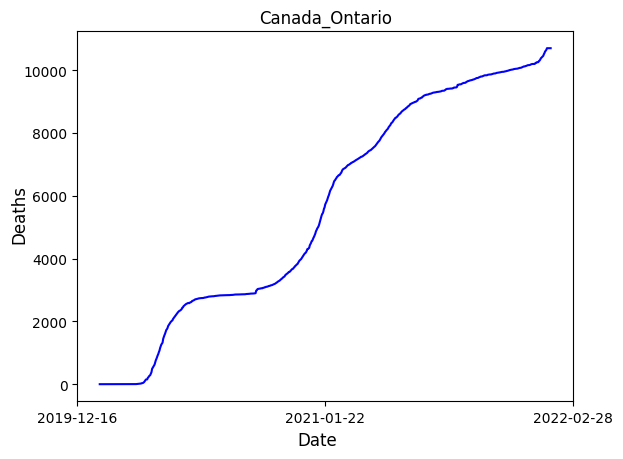

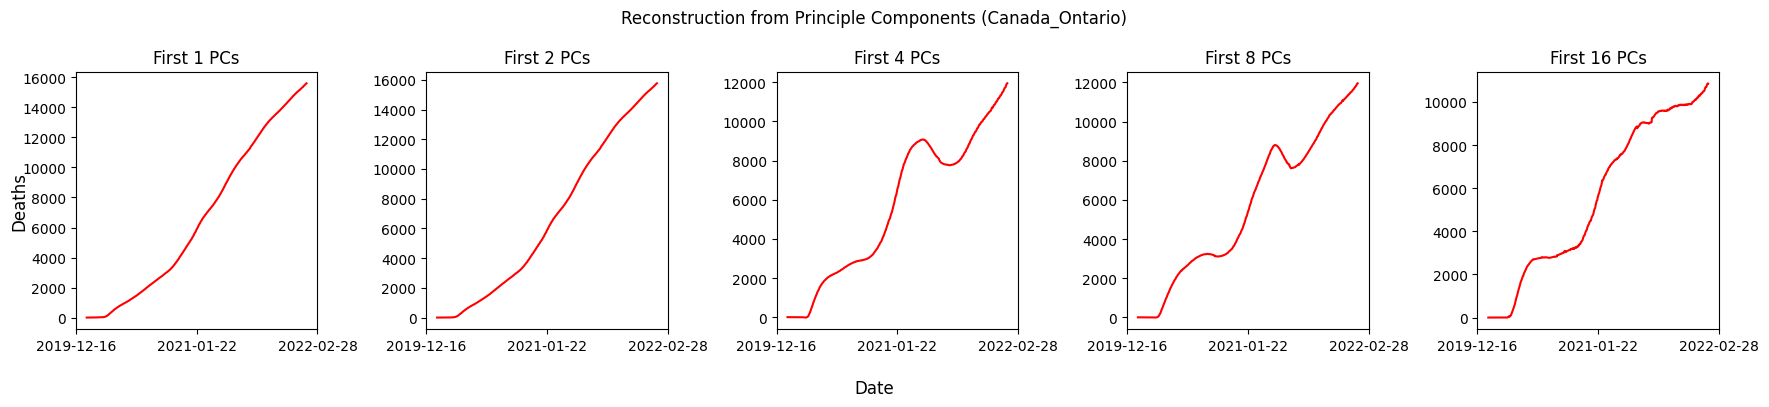

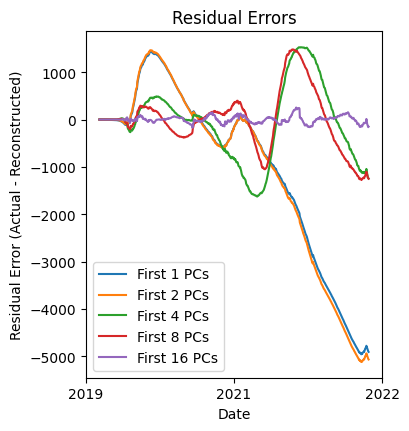

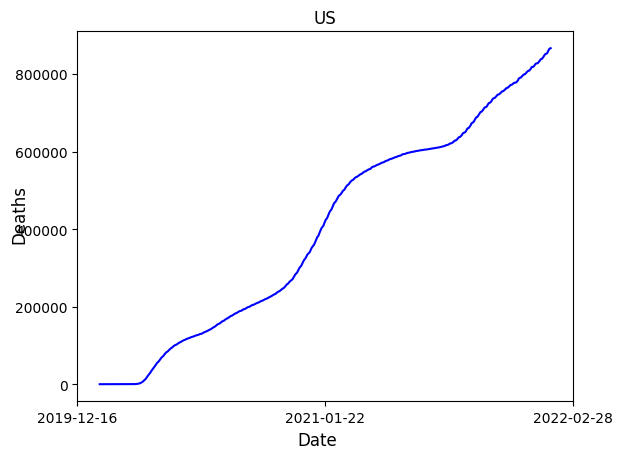

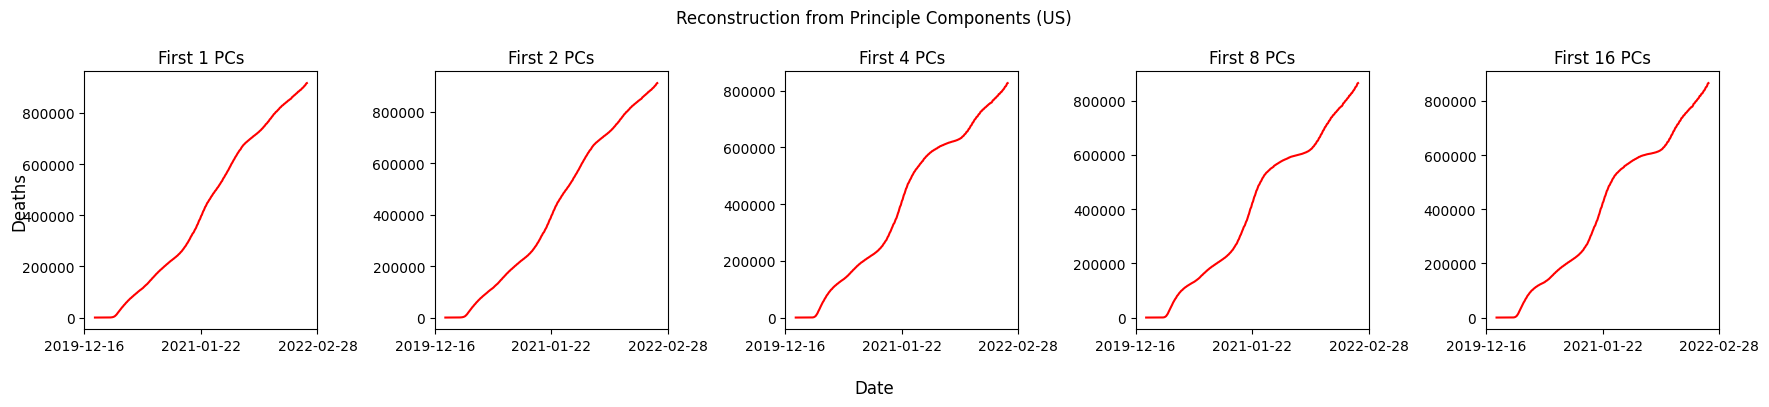

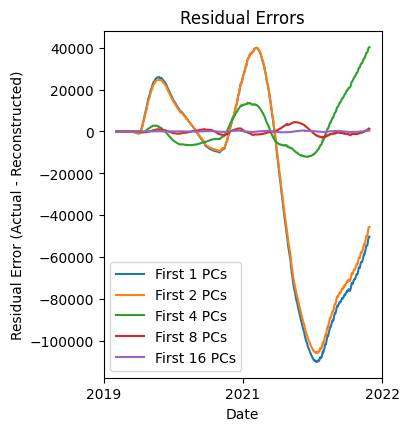

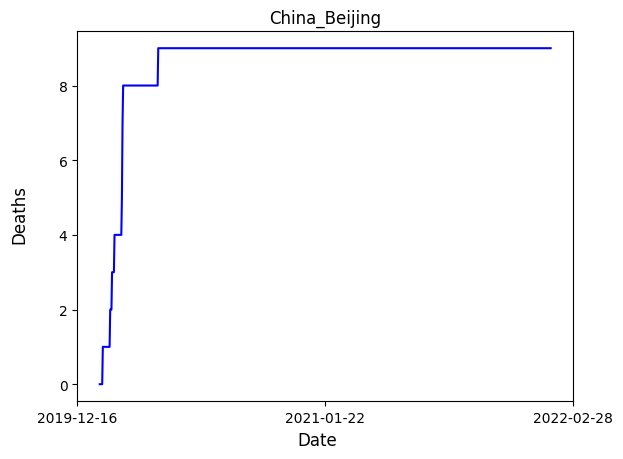

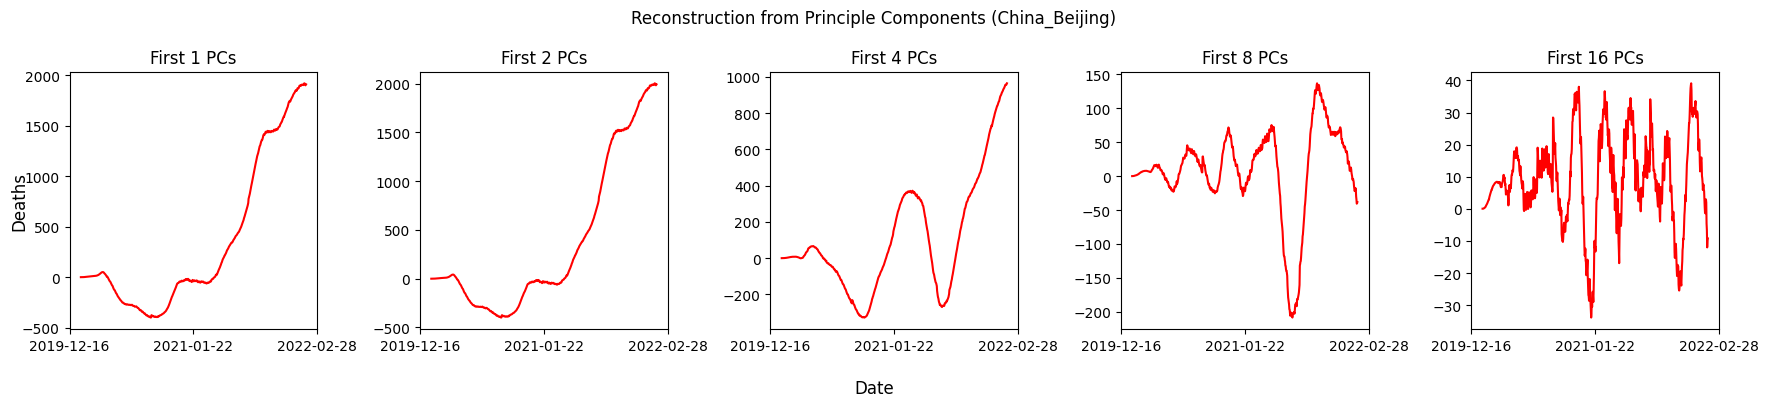

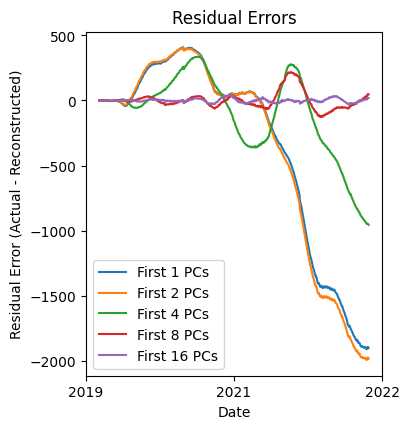

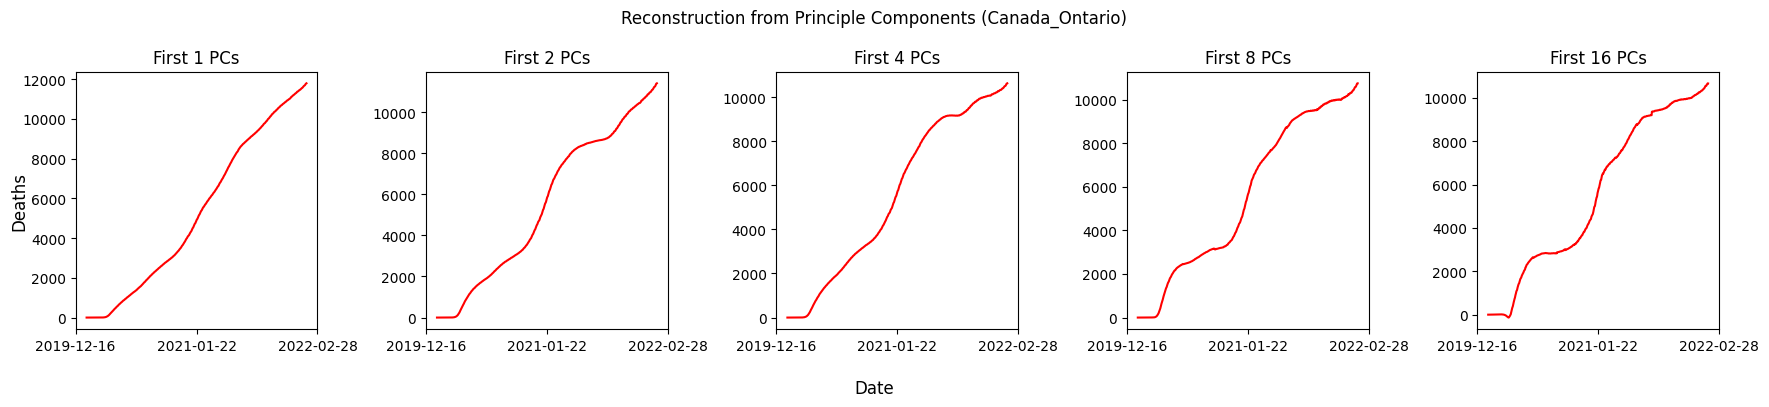

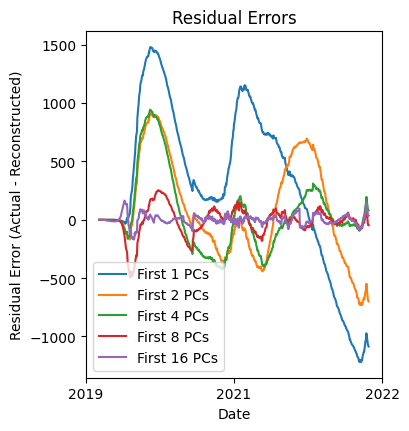

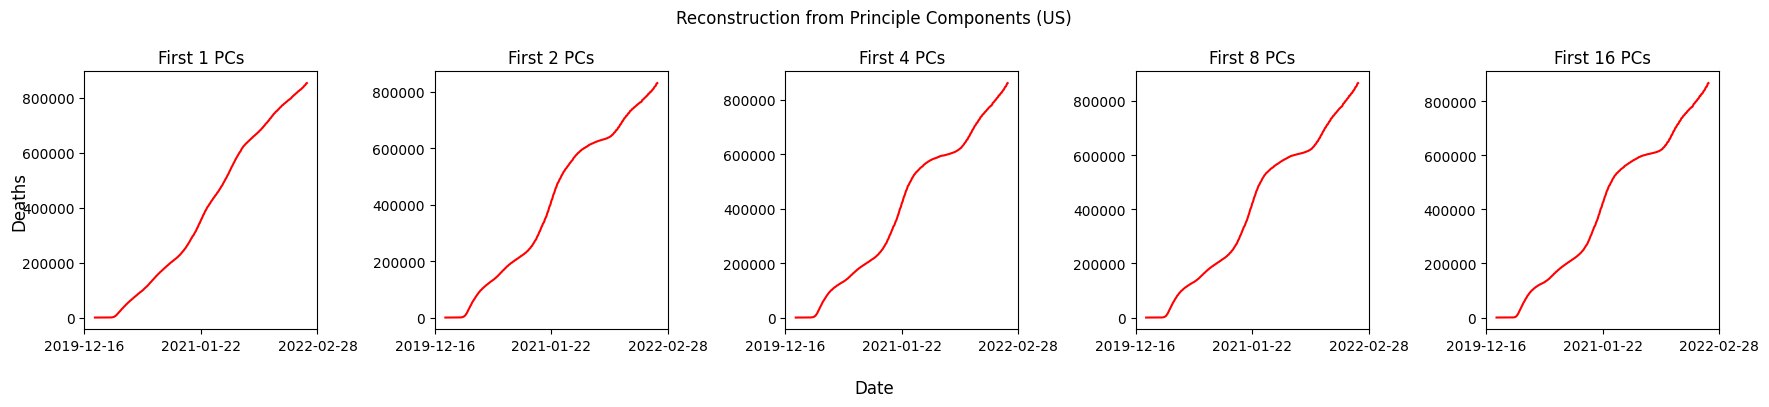

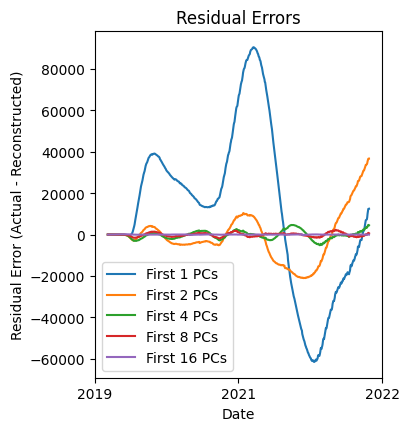

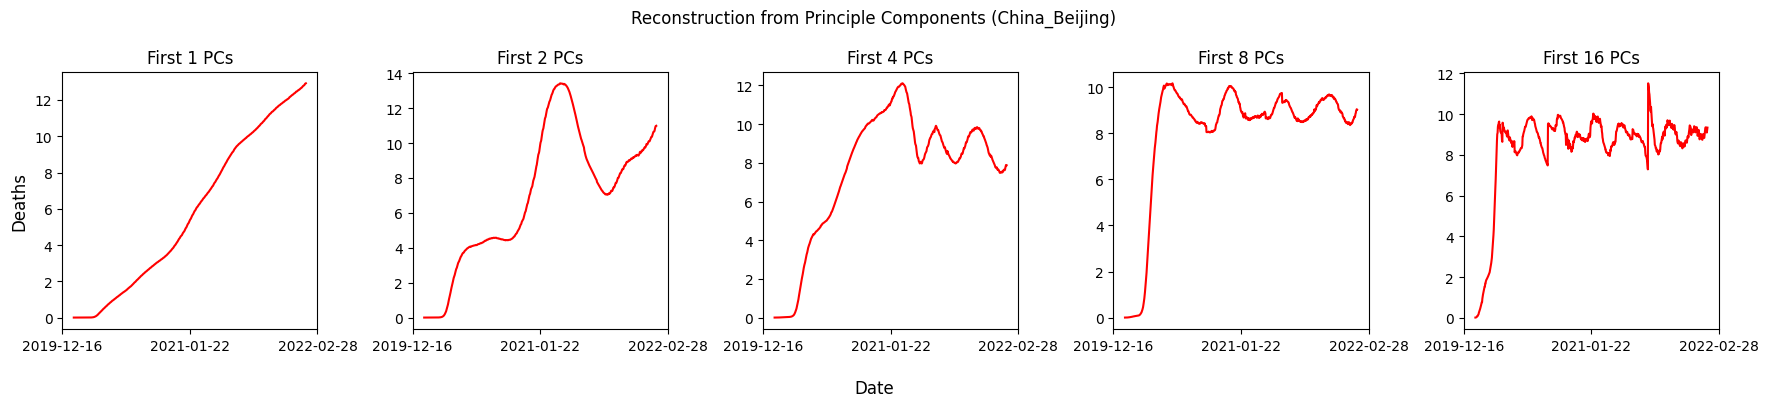

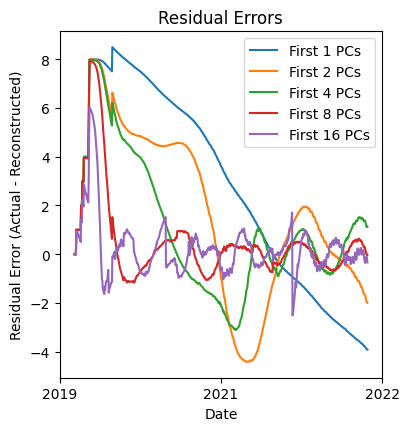

In [799]:
PCA_deaths_data = {
    'Canada_Ontario'        : plot_country_figures_PCA(covid_data, "Canada_Ontario", measurement='Deaths'),
    'US'                    : plot_country_figures_PCA(covid_data, "US", measurement='Deaths'),
    'China_Beijing'         : plot_country_figures_PCA(covid_data, "China_Beijing", measurement='Deaths')
}

SVD_deaths_data = {
    'Canada_Ontario'        : plot_country_figures_SVD(covid_data, "Canada_Ontario", measurement='Deaths'),
    'US'                    : plot_country_figures_SVD(covid_data, "US", measurement='Deaths'),
    'China_Beijing'         : plot_country_figures_SVD(covid_data, "China_Beijing", measurement='Deaths')
}


In [800]:
compare_PCA_SVD(PCA_deaths_data['Canada_Ontario'][1], SVD_deaths_data['Canada_Ontario'][1])


PCA RMSE     SVD RMSE Difference (SVD - PCA)
1   4384.053366  6643.387885            2259.334518
2   2084.367043    749.34795           -1335.019093
3    2166.22009   429.532015           -1736.688075
4   1054.076782   330.451888            -723.624894
5     798.12431   330.340244            -467.784066
6    756.546163   329.570383            -426.975781
7    570.667156   189.595948            -381.071208
8    494.499028   182.241745            -312.257283
9    625.049983   125.137761            -499.912222
10   249.746605   123.596289            -126.150315

In [801]:
compare_PCA_SVD(PCA_deaths_data['US'][1], SVD_deaths_data['US'][1])


PCA RMSE       SVD RMSE Difference (SVD - PCA)
1   469158.988396  479964.284092           10805.295696
2     51257.24739   40250.960771          -11006.286619
3    48958.532237   11789.137621          -37169.394616
4    20354.407291    3423.079758          -16931.327533
5    11482.657811    1993.179306           -9489.478504
6     6037.089565    1447.863498           -4589.226067
7     4718.873073    1400.633785           -3318.239288
8     4533.110757    1144.070479           -3389.040278
9     1475.919095     865.849372            -610.069722
10     991.362137     642.049244            -349.312893

In [802]:
compare_PCA_SVD(PCA_deaths_data['China_Beijing'][1], SVD_deaths_data['China_Beijing'][1])

PCA RMSE  SVD RMSE Difference (SVD - PCA)
1   10858.706419  8.713415          -10849.993003
2     805.876072  4.856634            -801.019437
3     846.817379  3.767875            -843.049504
4     613.315418  3.597618            -609.717801
5     330.401241  2.930725            -327.470515
6      98.715957  2.910794             -95.805163
7      62.182047  1.924482             -60.257565
8      58.201555  1.884536             -56.317019
9      66.386252  1.871746             -64.514506
10     41.212904  1.846639             -39.366265

Here SVD had a lower RMSE for all 3 countries over almost all PC count. For Beijing however, because they are so far (in-terms of variance) from the mean, neither PCA nor SVD were able to adequately recover the shape of the raw curve. 

In [804]:
%%cmd
jupyter nbconvert --to html "C:\Users\nurei\Documents\MIE\APS1070\project\3\W23_APS1070_Project_3".ipynb --HTMLExporter.theme=dark

Microsoft Windows [Version 10.0.22621.1265]
(c) Microsoft Corporation. All rights reserved.

(venv) c:\Users\nurei\Documents\MIE\APS1070\project\3>jupyter nbconvert --to html "C:\Users\nurei\Documents\MIE\APS1070\project\3\W23_APS1070_Project_3".ipynb --HTMLExporter.theme=dark


[NbConvertApp] Converting notebook C:\Users\nurei\Documents\MIE\APS1070\project\3\W23_APS1070_Project_3.ipynb to html
[NbConvertApp] Writing 6441646 bytes to C:\Users\nurei\Documents\MIE\APS1070\project\3\W23_APS1070_Project_3.html



(venv) c:\Users\nurei\Documents\MIE\APS1070\project\3>Clink v0.4.9 [git:2fd2c2] Copyright (c) 2012-2016 Martin Ridgers
http://mridgers.github.io/clink



# References

Understanding PCA and SVD:

1. https://towardsdatascience.com/pca-and-svd-explained-with-numpy-5d13b0d2a4d8

2. https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca

3. https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues

4. https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.8-Singular-Value-Decomposition/

PCA:

1. Snippets from: https://plot.ly/ipython-notebooks/principal-component-analysis/

2. https://www.value-at-risk.net/principal-component-analysis/

Covid Data:

1. https://www.worldometers.info/coronavirus/

2. https://datahub.io/core/covid-19#resource-time-series-19-covid-combined

